            Projet n°5 Catégorisez automatiquement des questions


Nous allons dans cette étude proposez une analyse textuelle des questions posées sur le site Stackoverflow. Notre objectif final est de suggérer des tags relatifs à la question posée afin d'aider les débutants dans leurs premiers pas sur le site.

Ce notebook représente l'analyse exploratoire des données

- <a href="#C1">1. Importation des données
- <a href="#C2">2. Analyse des données
    - <a href="#C2.1">2.1 Structure      
    - <a href="#C2.2">2.2 Champs vides et dupliqués  
    - <a href="#C2.3">2.3 Analyse univariée
    - <a href="#C2.4">2.4 Analyse multivariée
- <a href="#C3">3. Réduction des Posts
    - <a href="#C3.1">3.1 Nettoyage du code dans le corps du post
    - <a href="#C3.2">3.2 Nettoyage des Posts
        - <a href="#C3.2.1">3.2.1 Initialisation
        - <a href="#C3.2.2">3.2.2 Traitement de l'ensemble du corpus
        - <a href="#C3.2.3">3.2.3 Nettoyage des textes et des Tags
    - <a href="#C3.3">3.3 Analyse textuelle
        - <a href="#C3.3.1">3.3.1 Représentation visuelle
        - <a href="#C3.3.2">3.3.2 Analyse de la distribution des tokens
        - <a href="#C3.3.3">3.3.3 Nettoyage aprés analyse
- <a href="#C4">4. Sauvegarde du jeu de données nettoyé    


In [75]:
import os, sys, time
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from bs4 import BeautifulSoup

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import words

from guesslang import Guess

from pandarallel import pandarallel

In [3]:
# Download
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package omw-1.4 to /Users/claude/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/claude/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claude/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/claude/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
sns.set()
pandarallel.initialize(progress_bar=True, nb_workers=4, verbose=1)

# <a name="C1">1. Importation des données</a>

In [98]:
path="./data/source/"
os.listdir(path)

['.DS_Store', 'QueryResults1.csv', 'QueryResults2.csv']

In [99]:
#import warnings
#warnings.filterwarnings('ignore')
df = pd.DataFrame()
for idx, file in enumerate(os.listdir(path)):
    data = path + file
    df_part = pd.read_csv(data, index_col =0,encoding = 'latin1')   
    df = pd.concat([df, df_part], axis=0)

In [100]:
df.sample(10)

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75684637,How to define the return type of a function th...,"<p>For example, I develop an api and I have to...",<php><laravel>,-1,94,NaN,2
75834575,Python argparse: can flag be optional for one ...,<p>I have a python script that uses argparse t...,<python><arguments><argparse>,0,46,NaN,1
75674827,How can I ask for the username and password on...,<p>I know basics of scripting but not expert. ...,<perl>,3,62,NaN,1
75784018,How to find out available system fonts in Pyca...,<p>I'm writing SVG text in Pycairo and want to...,<python><windows><fonts><pycairo>,0,46,NaN,0
75833686,firebase service storage is not available - Re...,<p>I am trying to use firebase storage with Re...,<reactjs><firebase-storage>,0,35,NaN,1
75779695,Pytest - is there a way to not have to re writ...,<p>Is there a way to not have to re write this...,<python><unit-testing><pytest>,0,36,NaN,1
75764280,IE mode with InternetExplorerDriver,<p>Now Im using <code>selenium version 4.8.1</...,<selenium-webdriver><internet-explorer-11><int...,0,55,NaN,1
75709725,Python Random Int Generation returning 'None' ...,"<p>I have a very simple dice rolling program, ...",<python><random><nonetype><dice>,-1,39,NaN,1
75826861,"Appended Href links to a list, but the list is...",<p>i was scraping links out of this site below...,<pandas><list><beautifulsoup><python-requests>,1,25,NaN,1


# <a name="C2">2. Analyse des données</a>

## <a name="C2.1">2.1 Structure</a>

In [101]:
df.shape

(100000, 7)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 75598427 to 75871260
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          100000 non-null  object 
 1   Body           100000 non-null  object 
 2   Tags           100000 non-null  object 
 3   Score          100000 non-null  int64  
 4   ViewCount      100000 non-null  int64  
 5   FavoriteCount  8 non-null       float64
 6   AnswerCount    100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 6.1+ MB


In [103]:
df.dtypes.value_counts()

object     3
int64      3
float64    1
dtype: int64

In [104]:
df.nunique()

Title            99988
Body             99997
Tags             71932
Score               38
ViewCount          570
FavoriteCount        1
AnswerCount         11
dtype: int64

In [105]:
tmp = df.nunique()
tmp

Title            99988
Body             99997
Tags             71932
Score               38
ViewCount          570
FavoriteCount        1
AnswerCount         11
dtype: int64

In [106]:
tmp[tmp<10]

FavoriteCount    1
dtype: int64

In [107]:
tmp[tmp>100]

Title        99988
Body         99997
Tags         71932
ViewCount      570
dtype: int64

In [108]:
df.describe(include=np.number)

,Score,ViewCount,FavoriteCount,AnswerCount
count,100000.000000,100000.000000,8.0,100000.00000
mean,0.075100,44.973700,0.0,0.68235
std,1.863731,397.091052,0.0,0.78331
min,-10.000000,2.000000,0.0,0.00000
25%,0.000000,22.000000,0.0,0.00000
50%,0.000000,33.000000,0.0,1.00000
75%,0.000000,49.000000,0.0,1.00000
max,506.000000,104900.000000,0.0,11.00000


In [109]:
df.describe(include=object)

,Title,Body,Tags
count,100000,100000,100000
unique,99988,99997,71932
top,ModuleNotFoundError: No module named,"<p>If i have a circle that rotates, and reach'...",<python>
freq,3,2,672


## <a name="C2.2">2.2 Champs vides et dupliqués</a>

In [110]:
df.isna().sum()

Title                0
Body                 0
Tags                 0
Score                0
ViewCount            0
FavoriteCount    99992
AnswerCount          0
dtype: int64

In [111]:
df.isna().mean()

Title            0.00000
Body             0.00000
Tags             0.00000
Score            0.00000
ViewCount        0.00000
FavoriteCount    0.99992
AnswerCount      0.00000
dtype: float64

In [112]:
df.isna().mean().sort_values()

Title            0.00000
Body             0.00000
Tags             0.00000
Score            0.00000
ViewCount        0.00000
AnswerCount      0.00000
FavoriteCount    0.99992
dtype: float64

<AxesSubplot:ylabel='Id'>

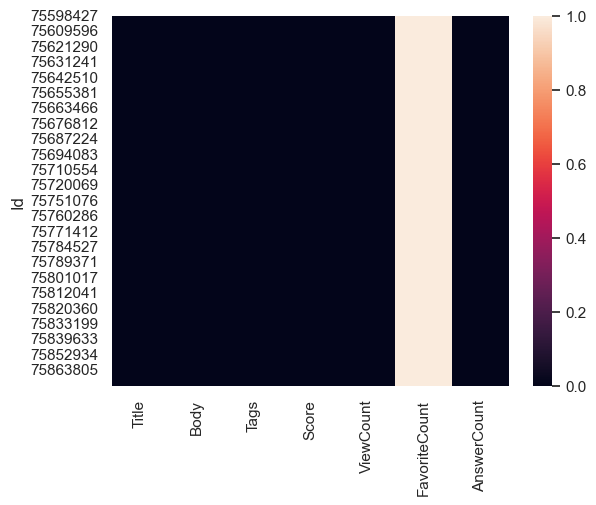

In [113]:
sns.heatmap(df.isna())

In [114]:
df.duplicated().sum()

0

In [115]:
df.columns

Index(['Title', 'Body', 'Tags', 'Score', 'ViewCount', 'FavoriteCount',
       'AnswerCount'],
      dtype='object')

In [116]:
df.Title.duplicated().sum()

12

In [117]:
idx = df.duplicated(subset='Title',keep=False)
df.loc[idx,].sort_values("Title")

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75771929,Error when launching the app for the second ti...,<p>I have an application in react native that ...,<storage><database><android><export><sqlite>,0,19,NaN,0
75761051,Error when launching the app for the second ti...,<p>I have an application in react native that ...,<database><react-native><sqlite><expo><typeorm>,1,22,NaN,0
75798572,How do I auto tabulate the Column in B and C o...,<p>How do I auto tabulate the Column in B and ...,<string><google-sheets><count><duplicates><tab...,0,27,NaN,0
75790496,How do I auto tabulate the Column in B and C o...,<p>How do I auto tabulate the Column in B and ...,<duplicates><automated-tests>,0,11,NaN,0
75948497,How to optimize a UDP socket for packet forwar...,<p>I'm doing packet forwarding through the use...,<networking><sockets><udp>,0,34,NaN,1
75859673,How to optimize a UDP socket for packet forwar...,<p>I'm doing packet forwarding through the use...,<c><sockets><networking><udp>,0,60,NaN,1
75776446,Is there a way to find uptime of legacy virtua...,<p>Is there a way to find uptime of legacy vir...,<batch-file><automation><windows-xp><rdp><uptime>,0,23,NaN,0
75780462,Is there a way to find uptime of legacy virtua...,<p>Is there a way to find uptime of legacy vir...,<batch-file><automation><windows-xp><rdp><uptime>,-1,10,NaN,0
75720308,ModuleNotFoundError: No module named,<p>Why when I try to import my file I get erro...,<python>,-2,18,NaN,0


In [118]:
df.Body.duplicated().sum()

3

In [119]:
idx = df.duplicated(subset='Body',keep=False)
df.loc[idx,].sort_values("Body")

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75608489,how to concatenate the [CLS] token from BERT l...,<p>I want to concatenate the last layer [CLS] ...,<python><nlp><bert-language-model><tf-idf>,0,33,NaN,0
75647744,how to concatenate the [CLS] token from BERT l...,<p>I want to concatenate the last layer [CLS] ...,<python>,0,27,NaN,0
75771738,how to get the relative rotation in degrees ev...,"<p>If i have a circle that rotates, and reach'...",<javascript><jquery><css>,0,70,NaN,1
75773144,How to get the relative angle or degrees even ...,"<p>If i have a circle that rotates, and reach'...",<javascript><html><jquery><css>,-3,17,NaN,0
75623351,Your branch is ahead of 'origin/branch-A' by 1...,<p>This is a known problem on SO. The solution...,<git><git-branch>,-1,49,0.0,1
75623523,Your branch is ahead of 'origin/branch-A' by 1...,<p>This is a known problem on SO. The solution...,<git><git-branch>,0,27,0.0,0


In [120]:
# Drop NaN
df.isna().mean()

Title            0.00000
Body             0.00000
Tags             0.00000
Score            0.00000
ViewCount        0.00000
FavoriteCount    0.99992
AnswerCount      0.00000
dtype: float64

In [121]:
# Drop duplicated
idx = df.duplicated(subset='Title',keep='first')
df.loc[idx,].sort_values("Title")

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75771929,Error when launching the app for the second ti...,<p>I have an application in react native that ...,<storage><database><android><export><sqlite>,0,19,NaN,0
75798572,How do I auto tabulate the Column in B and C o...,<p>How do I auto tabulate the Column in B and ...,<string><google-sheets><count><duplicates><tab...,0,27,NaN,0
75859673,How to optimize a UDP socket for packet forwar...,<p>I'm doing packet forwarding through the use...,<c><sockets><networking><udp>,0,60,NaN,1
75780462,Is there a way to find uptime of legacy virtua...,<p>Is there a way to find uptime of legacy vir...,<batch-file><automation><windows-xp><rdp><uptime>,-1,10,NaN,0
75654622,ModuleNotFoundError: No module named,"<p>(<a href=""https://i.stack.imgur.com/TvwN3.p...",<module><scrapy>,1,33,NaN,0
75720308,ModuleNotFoundError: No module named,<p>Why when I try to import my file I get erro...,<python>,-2,18,NaN,0
75825370,Next.js Failed to load static props (with reac...,<p>I saw in sentry that many users experience ...,<reactjs><next.js><vercel><react-query><nextjs...,0,33,NaN,0
75805543,Python GUI client and server connection always...,<p>So my python program is essentially an inve...,<python><sockets><user-interface><tkinter><fre...,-1,30,NaN,0
75790634,Scaleratio plotly,<p>There is the following solution to the prob...,<python><plotly>,0,21,NaN,0


In [122]:
df.drop_duplicates(subset='Title', keep='first', inplace =True)

In [123]:
df.drop_duplicates(subset='Body', keep='first', inplace =True)

## <a name="C2.3">2.3 Analyse univariée</a>

In [31]:
def affiche_distribution(data, col):
    """
    Side by side displot and boxplot in order to show the distribution of each feature    

Args: 
        data: type DataFrame     Name of the dataframe         
        col: type (String)       Name of the column
        
    Returns:
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
    
    sns.histplot(data=data, x=col, kde=True, ax=ax[0])
    ax[0].set_xlabel(f"{col}")
    ax[0].set_ylabel("Nombre d'observations")
    ax[0].set_title(f"Histograme de la variable {col}")
    
    sns.boxplot(data=data, x=col)
    ax[1].set_xlabel(f"{col}")
    ax[1].set_ylabel("Nombre d'observations")
    ax[1].set_title(f"Boîte à moustaches de la variable {col}")
    plt.show()
    print ("Statistiques de la variable : ")
    print (data[col].describe())

### Tags

In [32]:
df.Tags.value_counts(normalize=True)

<python>                                      0.006701
<javascript>                                  0.003741
<r>                                           0.003661
<html><css>                                   0.003380
<flutter><dart>                               0.003170
                                                ...   
<php><math><imagick><rectangles>              0.000010
<android><installation><crash><apk><adb>      0.000010
<joomla><font-awesome><joomla-template>       0.000010
<java><spring-boot><kotlin><apollo-client>    0.000010
<bluehost>                                    0.000010
Name: Tags, Length: 71925, dtype: float64

In [33]:
doc = df.Tags.sample(1)
doc = doc.values[0]
doc

'<java><postgresql><java-ee-7><ejb-3.2>'

In [34]:
tokens = word_tokenize(doc)
tokens = [w for w in tokens if w not in ["<", ">"]]

In [35]:
print (f"Nb tokens {len(tokens)}, Nb tokens uniques : {len(set(tokens))}")

Nb tokens 4, Nb tokens uniques : 4


In [36]:
def tokenit(doc):
    doc = doc.lower()
    tokens = word_tokenize(doc)
    tokens = [w for w in tokens if w not in ["<", ">"]]
    return len(set(tokens))

In [37]:
df["_nb_tags"] = df.Tags.apply(tokenit)

In [38]:
df._nb_tags.describe()

count    99986.000000
mean         3.119117
std          1.276815
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: _nb_tags, dtype: float64

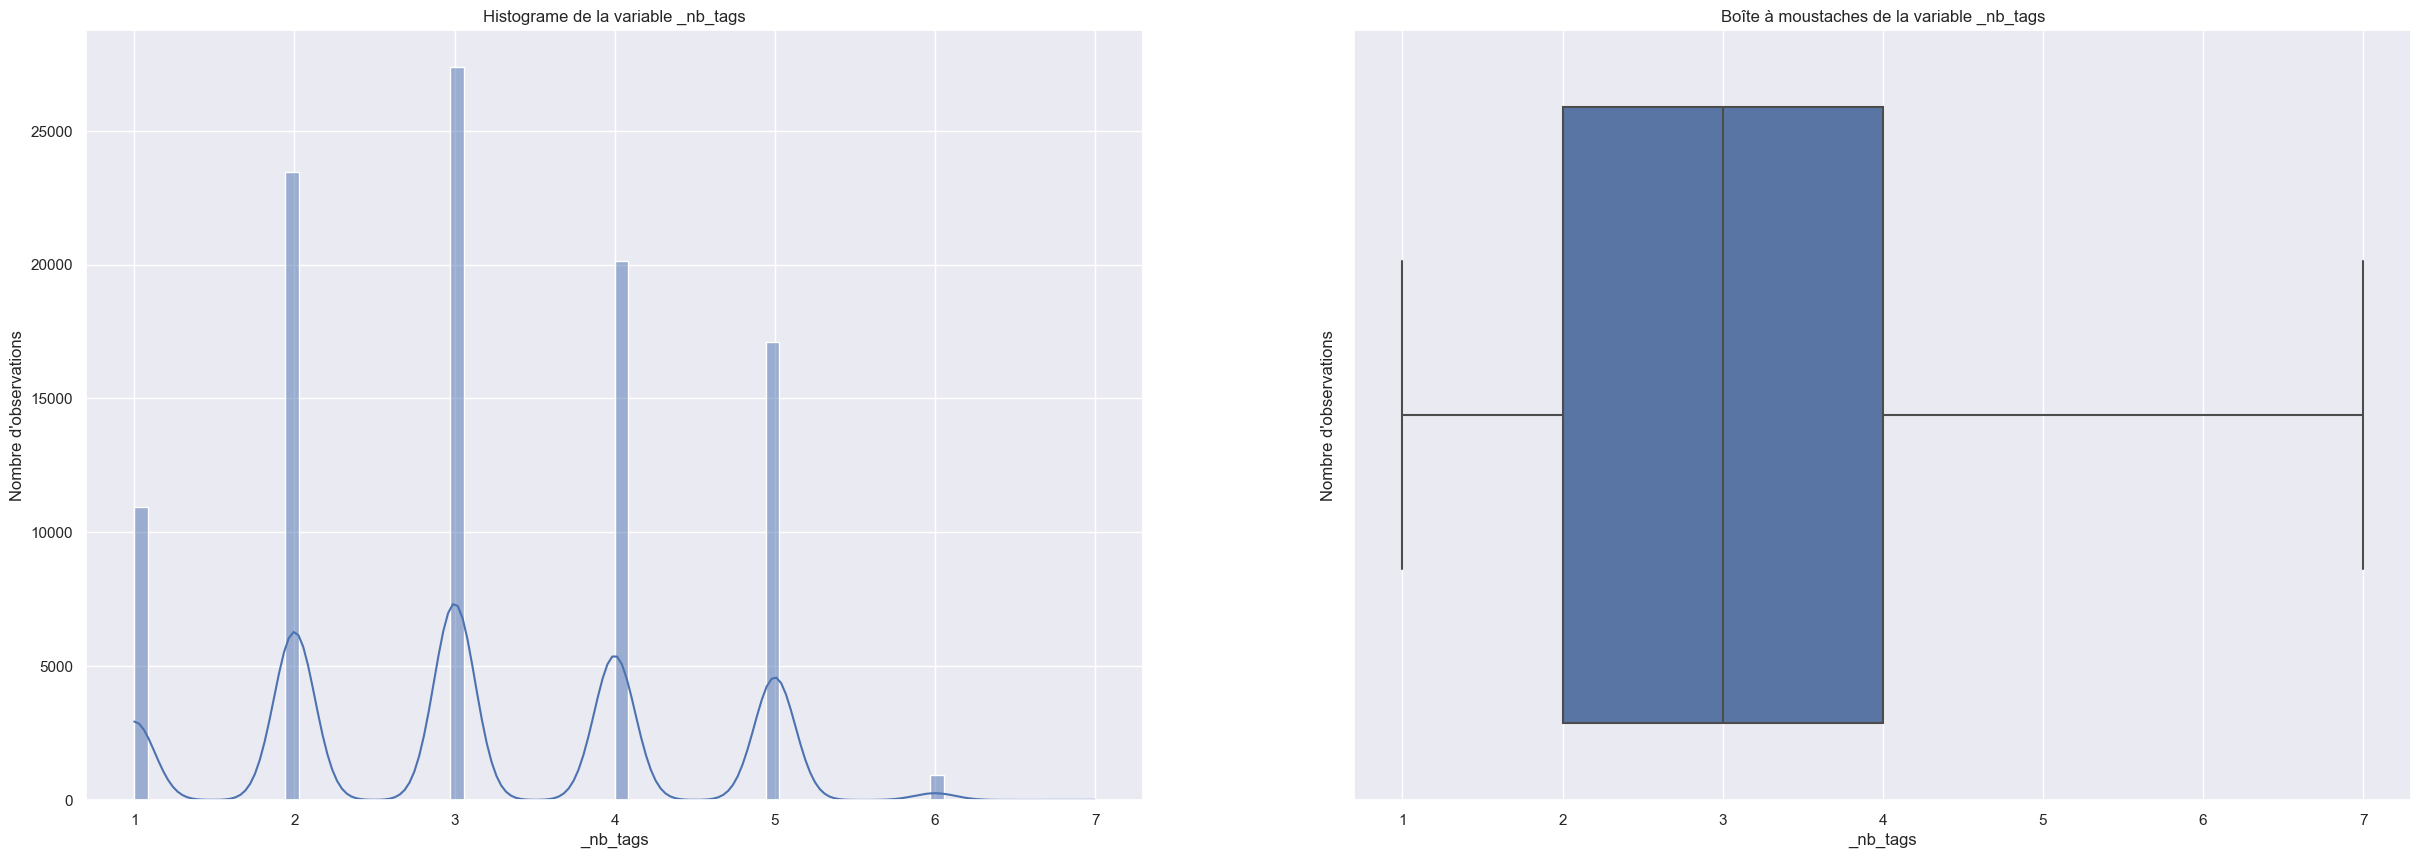

Statistiques de la variable : 
count    99986.000000
mean         3.119117
std          1.276815
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: _nb_tags, dtype: float64


In [39]:
affiche_distribution(data=df, col='_nb_tags')

### Title

In [40]:
df.describe(include='object')

,Title,Body,Tags
count,99986,99986,99986
unique,99986,99986,71925
top,can't find button with selenium webdriver,<p>This is really throwing us. I am working on...,<python>
freq,1,1,670


In [41]:
df["_len_Title"] = df.Title.apply(lambda i : len(i))

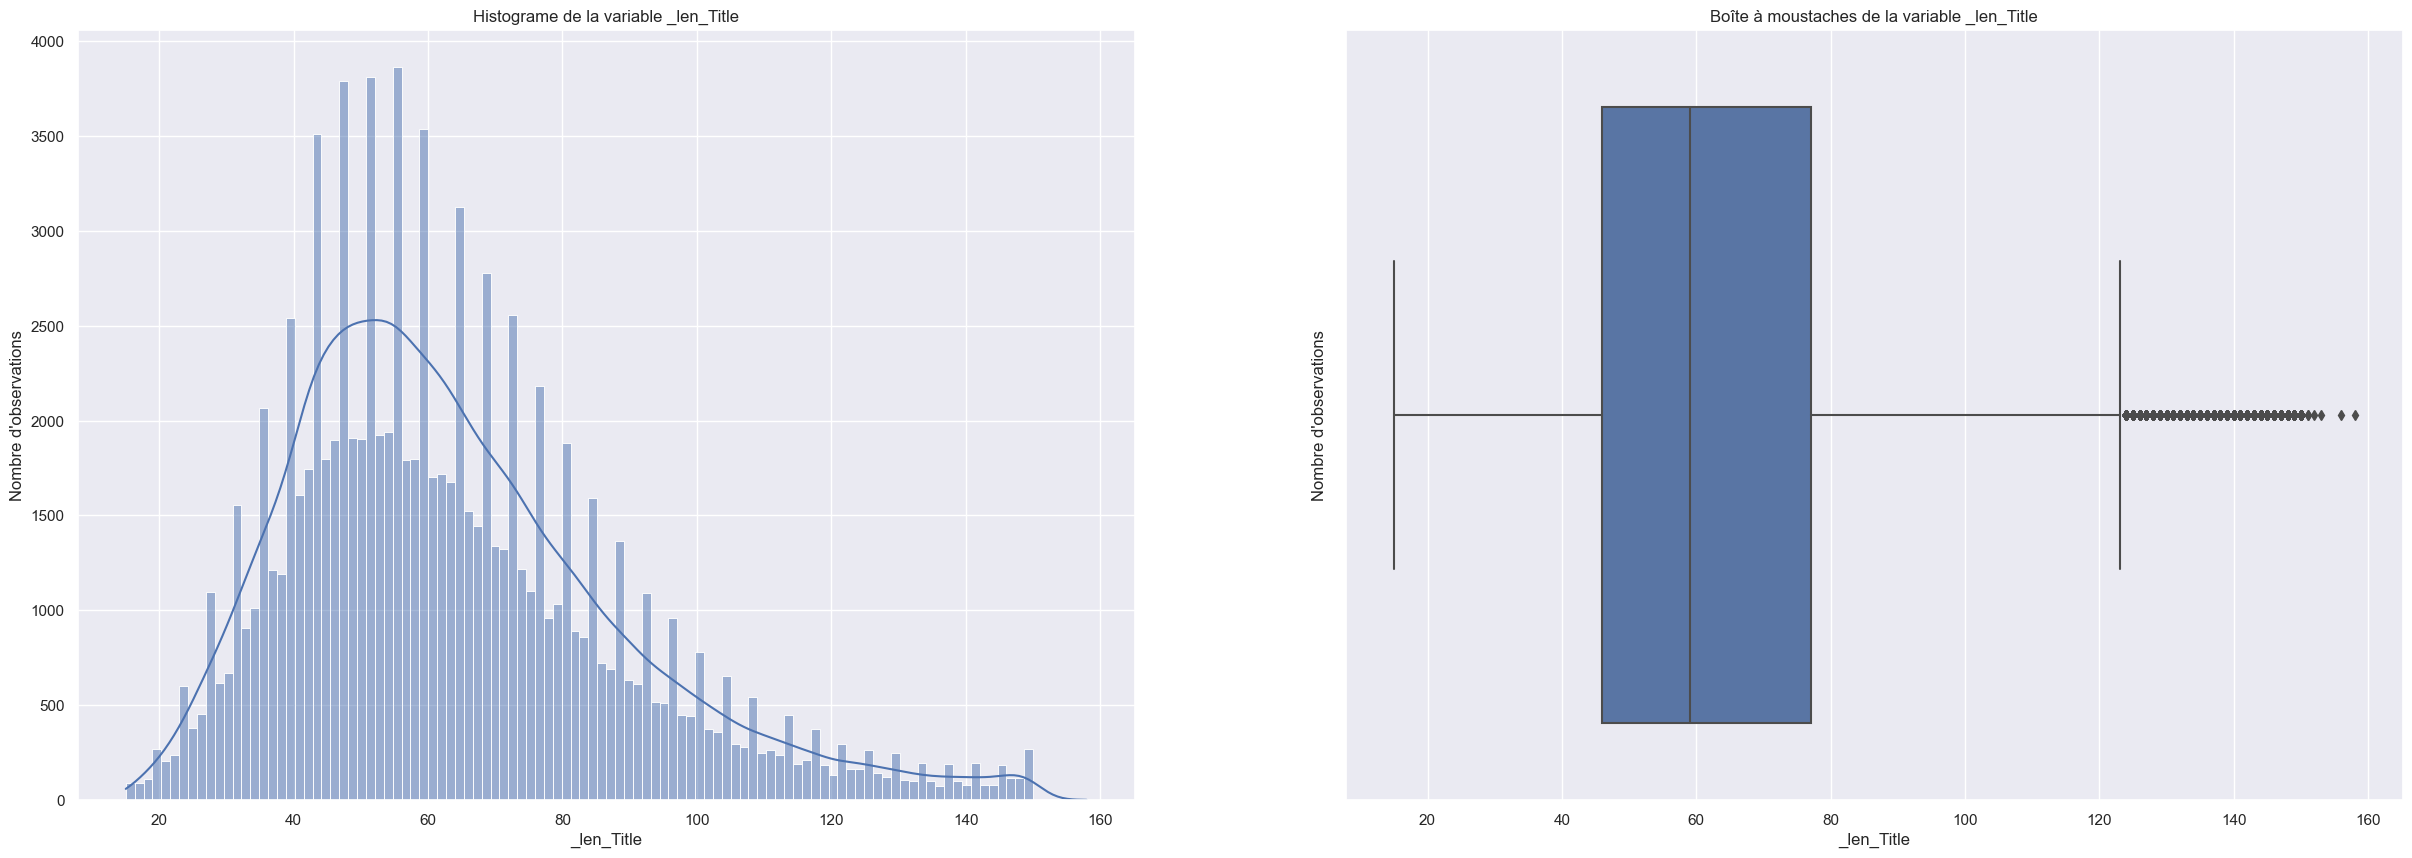

Statistiques de la variable : 
count    99986.000000
mean        63.624067
std         24.724605
min         15.000000
25%         46.000000
50%         59.000000
75%         77.000000
max        158.000000
Name: _len_Title, dtype: float64


In [42]:
affiche_distribution(data=df, col='_len_Title')

### Body

In [43]:
df["_len_Body"] = df.Body.apply(lambda i : len(i))

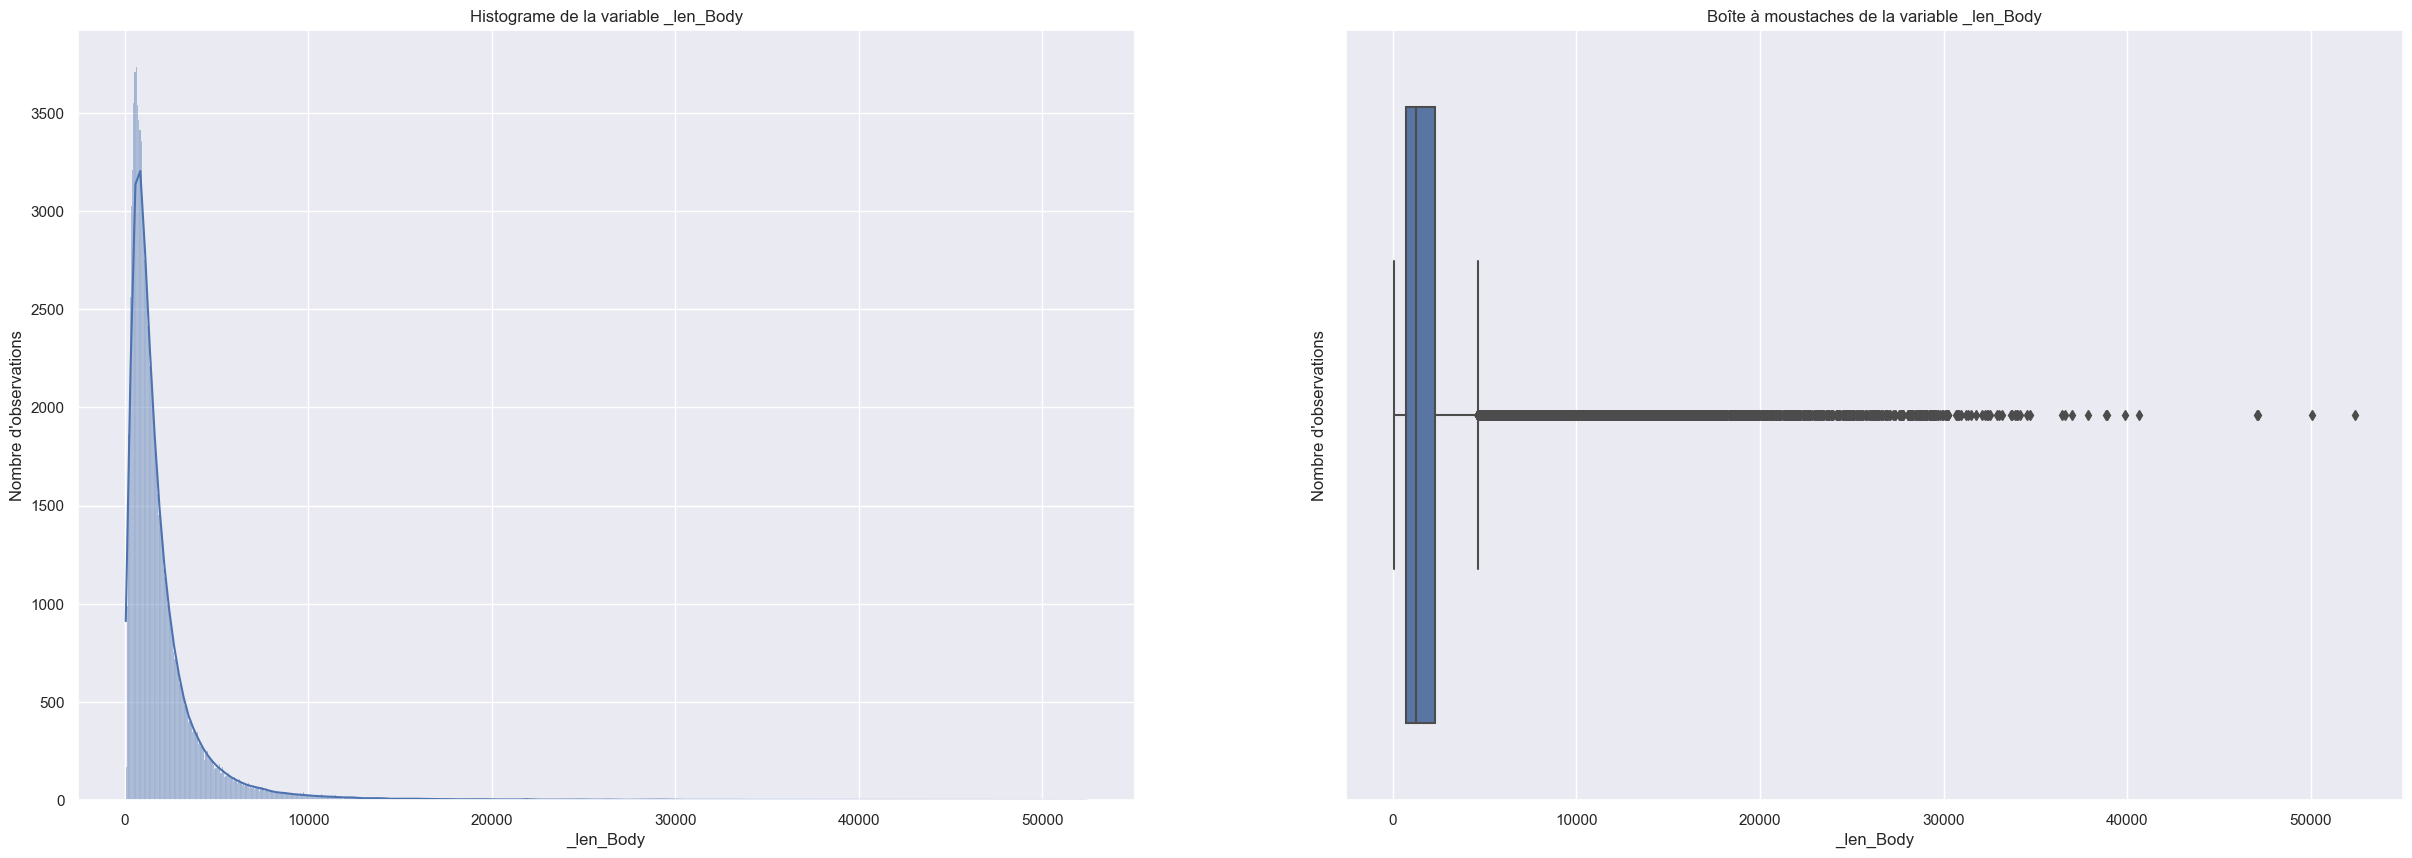

Statistiques de la variable : 
count    99986.000000
mean      1979.024463
std       2519.031564
min         56.000000
25%        708.000000
50%       1263.000000
75%       2282.000000
max      52407.000000
Name: _len_Body, dtype: float64


In [44]:
affiche_distribution(data=df, col='_len_Body')

### Score

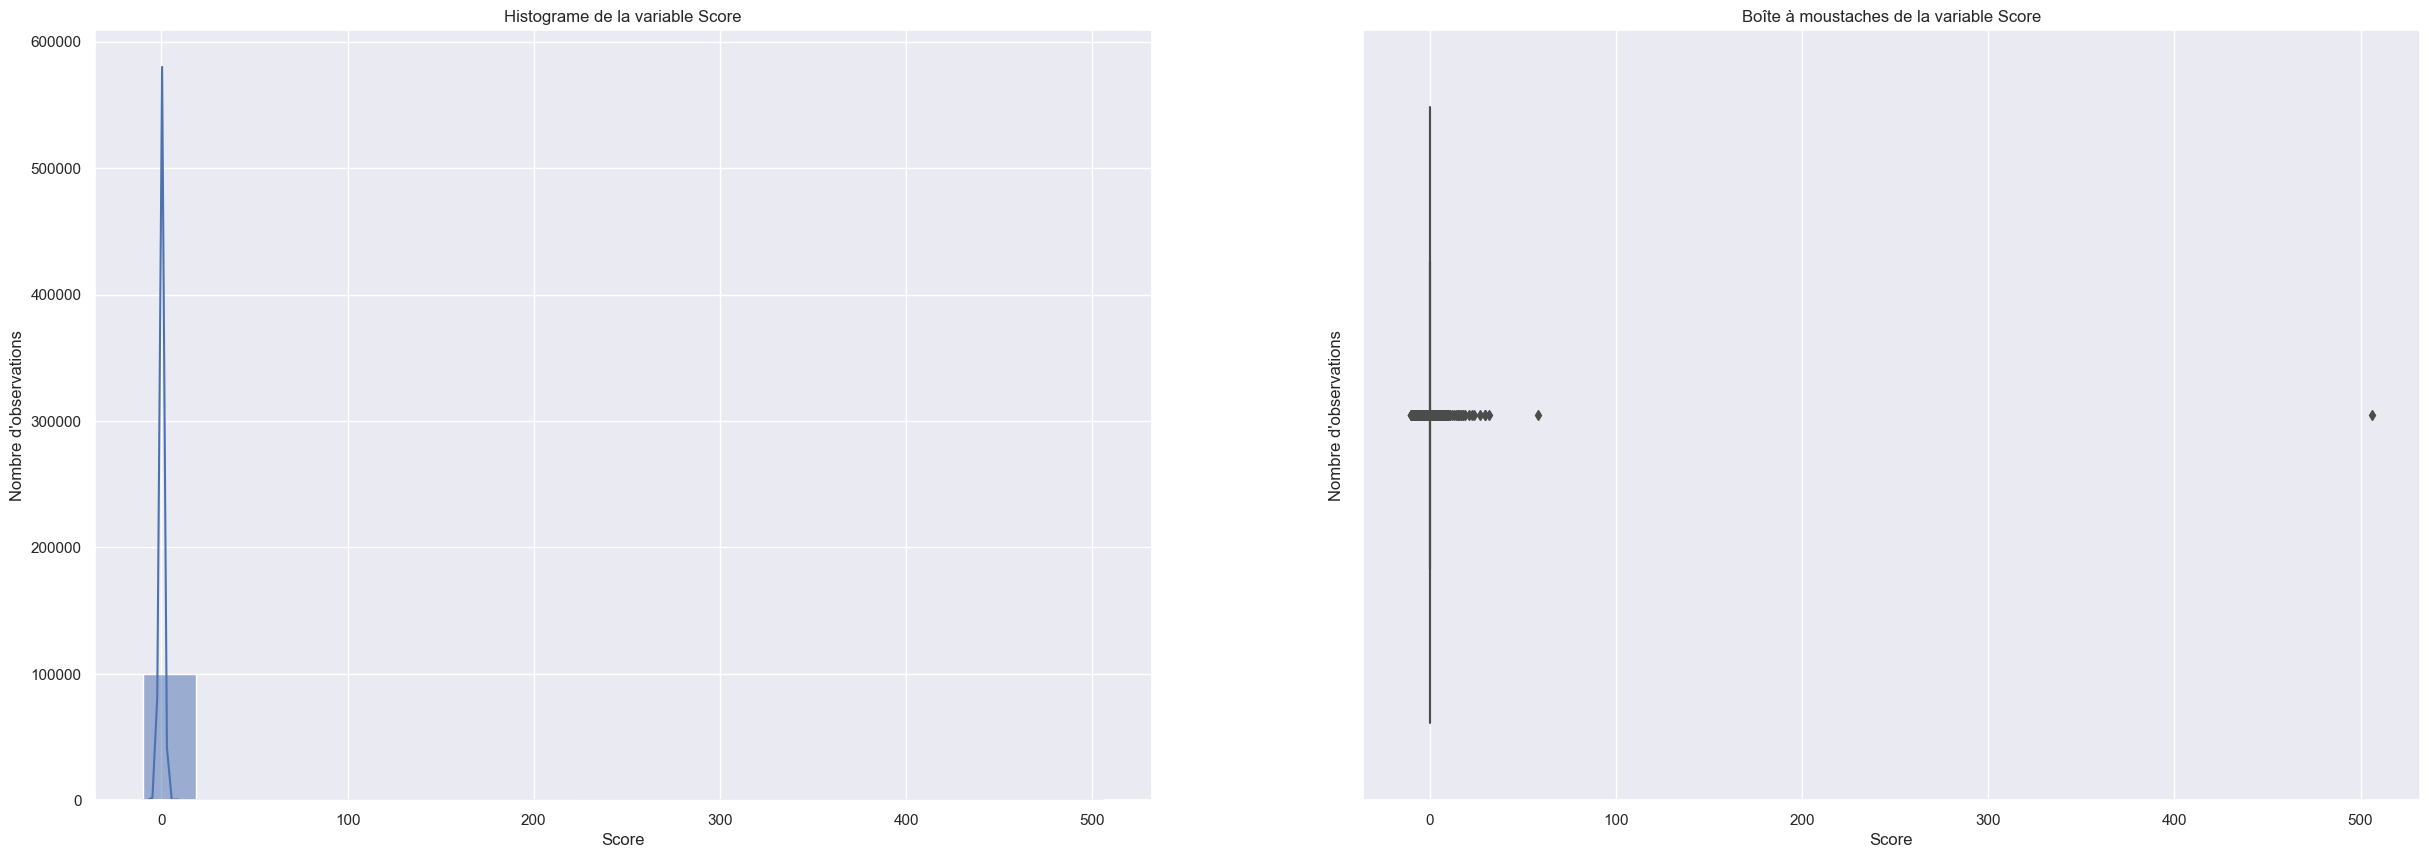

Statistiques de la variable : 
count    99986.000000
mean         0.075161
std          1.863814
min        -10.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        506.000000
Name: Score, dtype: float64


In [45]:
affiche_distribution(data=df, col='Score')

### ViewCount

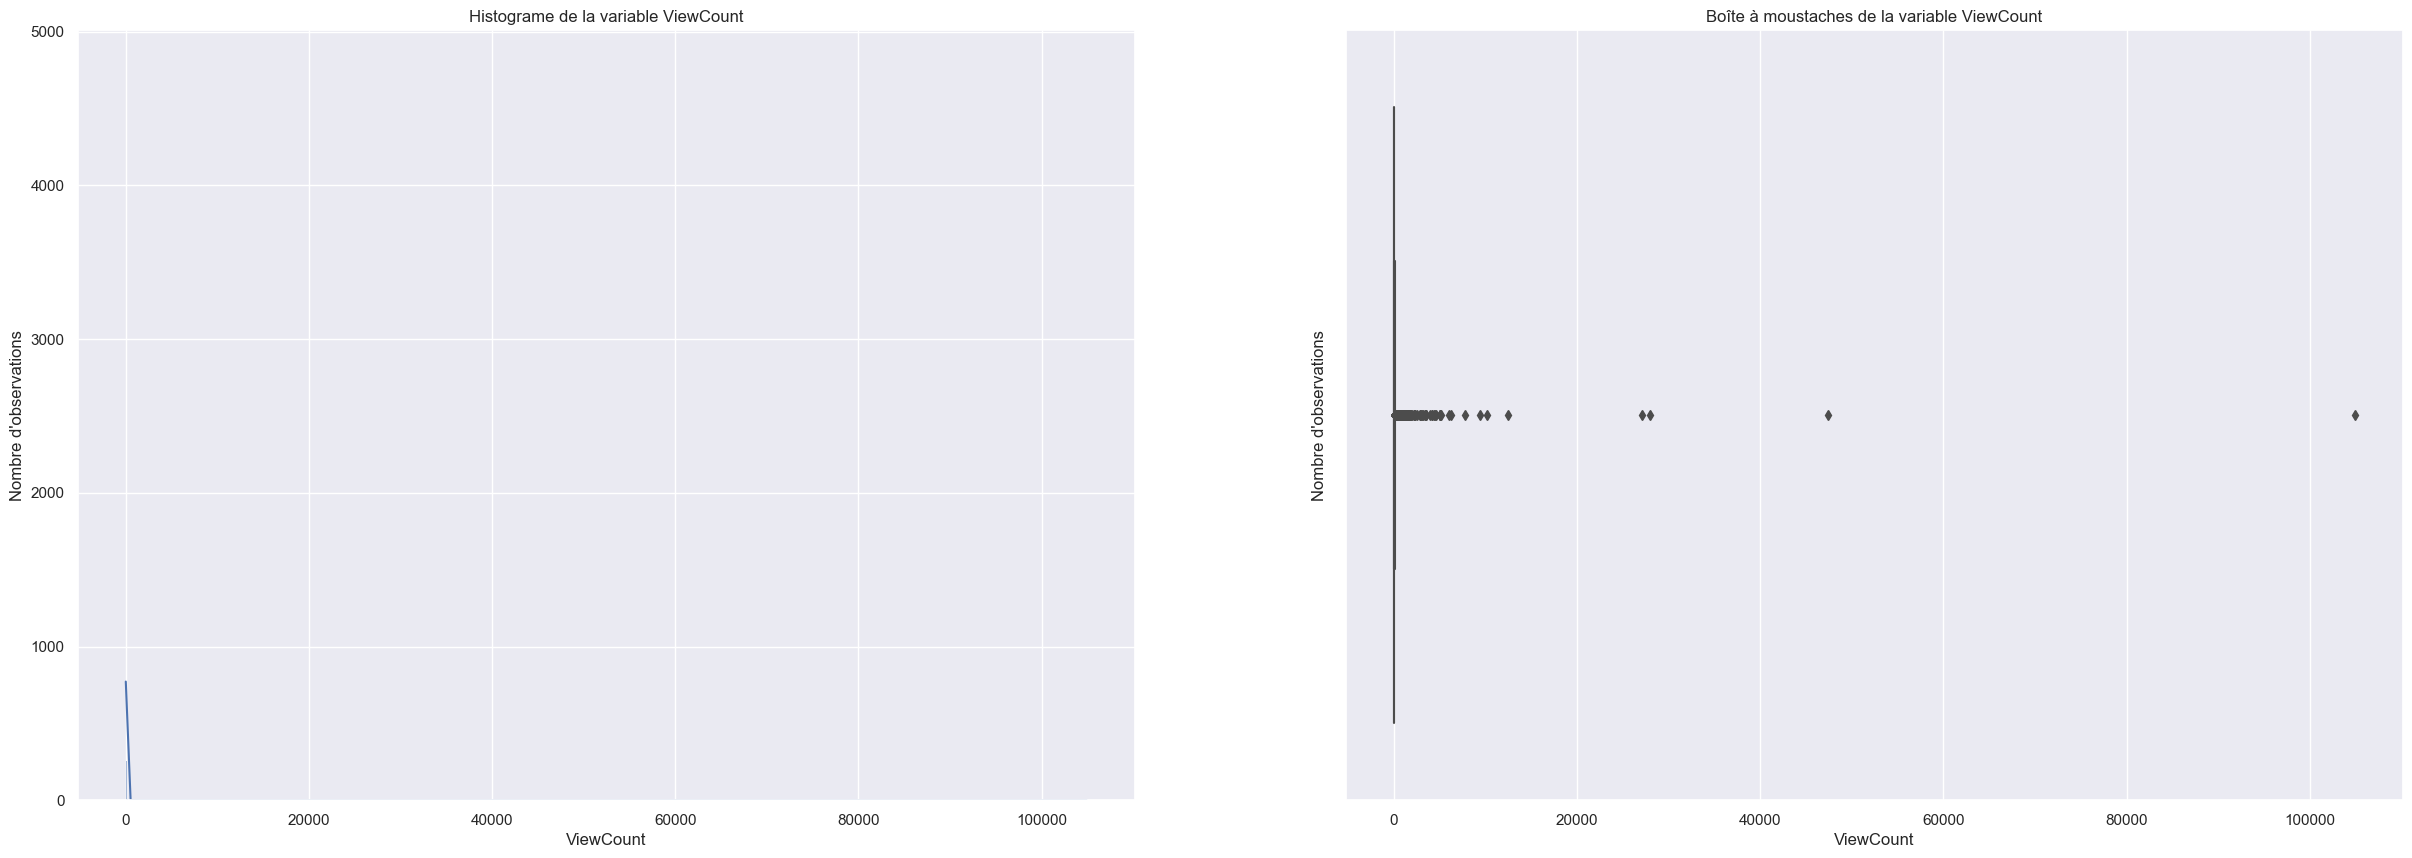

Statistiques de la variable : 
count     99986.000000
mean         44.975977
std         397.118763
min           2.000000
25%          22.000000
50%          33.000000
75%          49.000000
max      104900.000000
Name: ViewCount, dtype: float64


In [46]:
affiche_distribution(data=df, col='ViewCount')

## <a name="C2.4">2.4 Analyse multivariée</a>

In [47]:
corr = df.corr()

<AxesSubplot:>

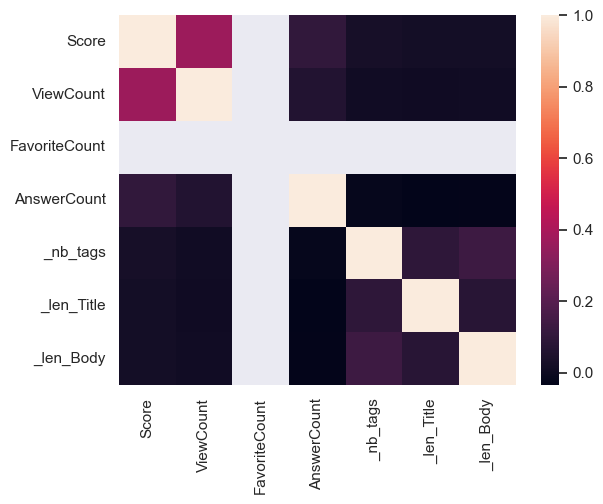

In [48]:
sns.heatmap(corr)

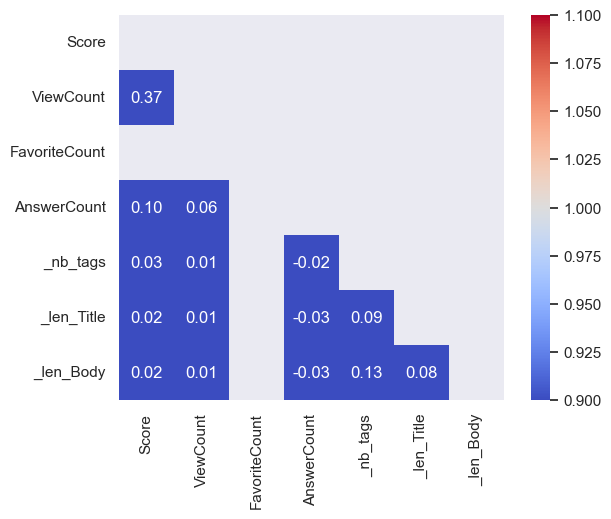

In [49]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax = sns.heatmap(corr,mask=mask, vmin=1, vmax=1, cmap='coolwarm', annot=True, fmt=('.2f'), square=True)

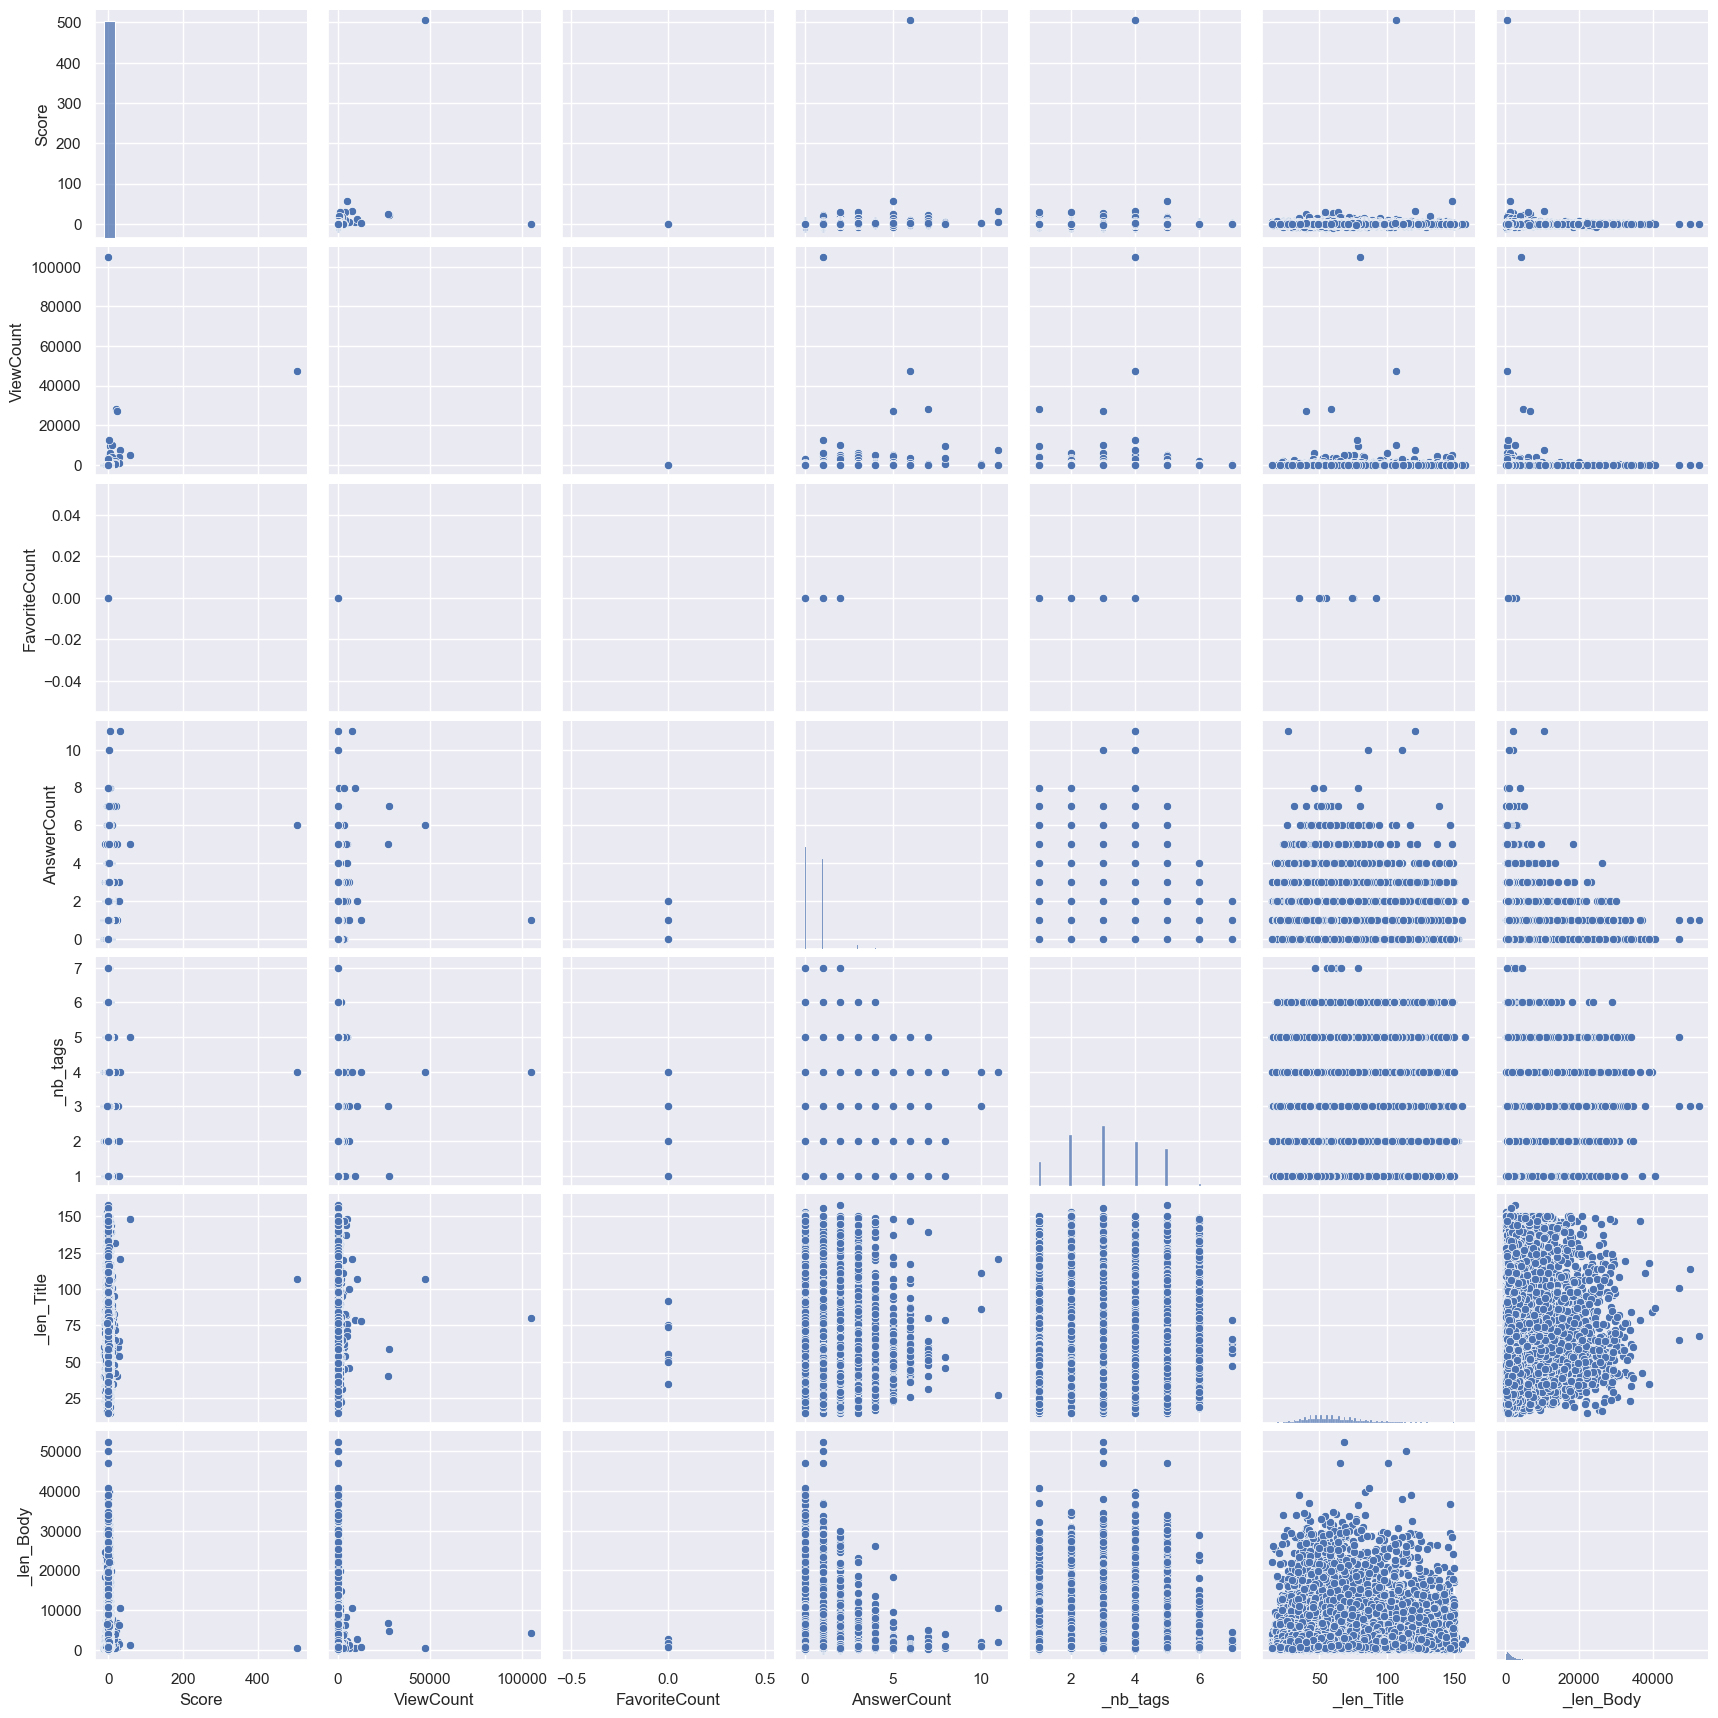

In [50]:
sns.pairplot(df)

In [51]:
# restriction aux données cibles
cols = ["Title", "Body", "Tags"]
df=df[cols]

# <a name="C3">3 Réduction dimensionnelle</a>

## <a name="C3.1">3.1 Nettoyage du code dans le corps du post</a>

In [124]:
# print n random documents
df_samp = df.sample(20)
df_samp

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75635052,tmLanguage: how to match custom patterns in match,<p>I'm developing a VS Code extension for a sm...,<vscode-extensions><tmlanguage>,0,21,NaN,0
75601440,Remove the preceeding duplicate index value an...,<pre><code>index = [461 470 479 488 489 490 49...,<python><dataframe><if-statement><null><break>,0,37,NaN,1
75642929,Add a bookmark to Microsoft Edge bookmark bar ...,<p>I would like to add a bookmarklet to Edge b...,<powershell><browser><microsoft-edge><bookmark...,1,137,NaN,2
75670350,Linux/C/mmap: Delay involved with IPC mechanis...,<p>I have two processes(let's say process1 and...,<c><linux><linux-kernel><shared-memory><mmap>,0,49,NaN,0
75608719,Can't build unity project,<p>as im not to fimiliar with these sorts of p...,<unity3d><build><compiler-errors>,0,41,NaN,1
75725763,Faulty returncode of subprocess.run(),"<pre class=""lang-py prettyprint-override""><cod...",<python><python-3.x><subprocess>,0,17,NaN,1
75628958,IDEA Docker run target. ClassNotFound,<p>I am trying to run simple hello-world proje...,<docker><intellij-idea>,0,11,NaN,0
75622705,I keep getting an error when using the fetch m...,<p>I'm using a tool called sanity to store my ...,<reactjs><react-native><react-hooks>,0,108,NaN,1
75638283,C#/Selenium testing on a physical android device,<p>So I have this automation test which I want...,<c#><android><selenium-webdriver>,0,95,NaN,1


In [32]:
for idx, ser in df_samp.iterrows():
    print (f"Tags : {ser['Tags']}")
    print (f"Titre : {ser['Title']}")
    print (f"Texte : {ser['Body']}\n")    

Tags : <javascript><angular><asp.net-core><file-upload><http-post>
Titre : Uploading Large file over httpPost throws unknown error in Angular 14
Texte : <p>I have a simple ractive angular form for uploading files, and there's ASP.core for backend.
sending the file to the api over HTTP post stops midway after like 10 seconds and returns an UNKNOWN ERROR with code 0 only if the file is larger than around 10MB or so. small sized files are uploaded just fine.</p>
<p>The ASP.NET API as of now just returns a message after recieving the form and no proccessing. So the file won't even reach the server. Plus, sending the same large files with Postman works just fine. and there's no limit on file size on the Backend so the problem has to be the client-side.</p>
<p>I even rewrote the code using <a href="https://code-maze.com/upload-files-dot-net-core-angular/" rel="nofollow noreferrer">this</a> tutorial. result is the same even though it works with Postman but my angular app fails.</p>
<pre><code

In [125]:
# Le corps du post est nettoyé du code qu'il pourrait contenir
def isoler_code(texte):
    texte_code = texte[texte.find("<pre><code>") + len ("<pre><code>"):texte.find("</code></pre>")]
    return texte_code

In [128]:
def renseigne_code(row):
    code_text = ""
    body_text = row['Body']
    while (body_text.find("<pre><code>") != -1):    
        pgm_text = isoler_code(body_text)
        code_text = "".join([code_text, pgm_text])
        body_text = body_text.replace("<pre><code>","",1)
        body_text = body_text.replace(pgm_text,"")
        body_text = body_text.replace("</code></pre>","",1)
    row['Body'] = body_text
    row["Code"] = code_text
    return row

In [129]:
pd.set_option('mode.chained_assignment',None)
df = df.apply(renseigne_code, axis=1)
%time

CPU times: user 7 µs, sys: 4 µs, total: 11 µs
Wall time: 720 µs


In [168]:
#from whats_that_code.election import guess_language_all_methods
def cherche_langage(text):
    guess = Guess()
    langue = ""
    try :
        if len(text) != 0:
#        langue = guess_language_all_methods(text)
            langue = guess(text[0][0][0:-1])
    except TypeError:
        print ("Langue inconnue")
    return langue

In [169]:
# Le langage de programmation est conservé pour un éventuel traitement ultérieur
df['Langue'] = df['Code'].apply(lambda txt : cherche_langage(txt))
df['Langue']

Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue i

Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue i

Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue i

Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue i

Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue i

Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue inconnue
Langue i

KeyboardInterrupt: 

In [85]:
df_samp = df.loc[df.Title == "Uploading Large file over httpPost throws unknown error in Angular 14"]
for idx, ser in df_samp.iterrows():
    print (f"Tags : {ser['Tags']}")
    print (f"Titre : {ser['Title']}")
    print (f"Code : {ser['Code']}\n")  

Tags : <javascript><angular><asp.net-core><file-upload><http-post>
Titre : Uploading Large file over httpPost throws unknown error in Angular 14
Code : progress: number;
message: string;
@Output() public onUploadFinished = new EventEmitter();

constructor(private http: HttpClient) { }

uploadFile = (files: any) =&gt; {
 if (files.length === 0) {
   return;
 }
 let fileToUpload = &lt;File&gt;files[0];
  const formData = new FormData();
formData.append('file', fileToUpload, fileToUpload.name);

 this.http.post('https://localhost:44468/api/upload', formData, { reportProgress: true, 
  observe: 'events' })
    .subscribe({
     next: (event: any) =&gt; {
       if (event.type === HttpEventType.UploadProgress)
         this.progress = Math.round(100 * event.loaded / event.total);
      else if (event.type === HttpEventType.Response) {
         this.message = 'Upload success.';
         this.onUploadFinished.emit(event.body);
       }
     },
     error: (err: HttpErrorResponse) =&gt; consol

In [170]:
df.Langue.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Langue'

In [154]:
cols = ["Title", "Body", "Tags", "Langue"]
df=df[cols]
df.rename(columns = {'Langue':'Language'}, inplace = True)
df

,Title,Body,Tags,Language
Id,,,,
75598427,can't find button with selenium webdriver,<p>This is really throwing us. I am working on...,<python><html><selenium-webdriver><automation>...,java
75598430,How to generate all possible melody strings fo...,"<p>I have this question in the Math site, to f...",<algorithm>,haskell
75598432,Create access policy for NiFi using REST API,<p>I am trying to set an access policy to a Ni...,<python><rest><apache-nifi>,haskell
75598434,"node-gyp ld: warning: ignoring file <file>, bu...",<p>I am getting this error in Github Actions r...,<node-gyp>,haskell
75598435,Update a table based on the existence of a row...,"<p>This is a bit confusing to explain, but bas...",<mysql><sql>,c#
...,...,...,...,...
75869704,how to filter efficiently for many terms,"<p>First, I *do *have a solution to this, than...",<r><dataframe><filter><data-wrangling>,python
75872804,Related to Databricks policies,<p>need to write powershell script for Databri...,<powershell>,None
75868369,Creating a table with two colon delimited strings,<p>I am currently trying to make a PL/SQL func...,<plsql><oracle-apex>,None


In [155]:
df.to_csv("data/cleaned/df_cleaned.csv", index=False)

## <a name="C3.2">3.2 Réduction des Posts</a>

### <a name="C3.2.1">3.2.1 Initialisation</a>

In [42]:
df = pd.read_csv("data/cleaned/df_cleaned.csv") 

#### Fonctions de traitement des textes

In [50]:
def tokens_display_info(tokens):
    print (f"Nb tokens {len(tokens)}, Nb tokens uniques : {len(set(tokens))}")

In [51]:
def process_text(doc, 
                   rejoin=False,
                   lemm_or_stemm ="stem",
                  list_rare_words=None,
                  min_len_word=3,
                  force_is_alpha=True):
    
    """basic function of text processing 
    positional arguments :
    --------------------
    doc : str : the document to process
    
    opt args :
    --------
    rejoin : bool : if True return a string else return the list of tokens
    lemm_or_stemm : str : apply lemmatize or stemmatize
    list_rare_words : list : a list of rare words to exclude
    min_len_word : int : the miminmum length of words to not exclude
    force_is_alpha : int : if 1, exclude all tokens with a numeric character
    
    return :
    -------
    a string (if rejoin is True) or a list of tokens
    
    """
    
    # liste_unique_words
    if not list_rare_words:
        list_rare_words = []
    
    # lower 
    doc = doc.lower().strip()
    
    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    
    # stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    
    # no rare tokens
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    
    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]
    
    # if only alpha chars
    if force_is_alpha :
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else :
        alpha_tokens = more_than_N 
    
    # lemm or stemm
    if lemm_or_stemm == "lemm" :
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else :
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]
    
    if rejoin : 
        return " ".join(trans_text)
    return trans_text

#### Initialisation des Stops-words

In [52]:
stop_words = stopwords.words('english')
print (stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [53]:
pd.Series(words.words()).sample(10)

126425    nonincarnated
231987          whistle
145991     physiologist
142953       peristylos
99187          itonidid
144709     philosophism
214495       underplant
134332         overbred
109836           madame
34174     Chelidosaurus
dtype: object

#### Initialisation des mots en anglais

In [57]:
len(set(words.words()))

235892

In [58]:
eng_words = [i.lower() for i in words.words()]
eng_words[:10]

['a',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'aani',
 'aardvark',
 'aardwolf',
 'aaron']

In [59]:
lm = WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]
tokens_display_info(eng_words_lem)

Nb tokens 236736, Nb tokens uniques : 233450


### <a name="C3.2.2">3.2.2 Traitement de l'ensemble du corpus</a>

In [60]:
corpus_Title = "".join(df.Title.values)
corpus_Body = "".join(df.Body.values)

In [61]:
raw_corpus = corpus_Title + corpus_Body

In [62]:
corpus = process_text(raw_corpus, rejoin=False)
pd.Series(corpus).sample(10)

7381127      color
5598592    everyth
8324416      claus
5648817     column
1784964       data
4236098        nio
7832823       quot
2249459     refund
2929493       quot
7039365       java
dtype: object

In [63]:
tmp = pd.Series(corpus).value_counts()
res = []
for i in range(1,50):
    liste_n_words = tmp[tmp<=i]
    res.append(len(liste_n_words))

In [64]:
dfr = pd.DataFrame(res, columns=["Nb_words"])

In [65]:
len(corpus)

8576913

<AxesSubplot:>

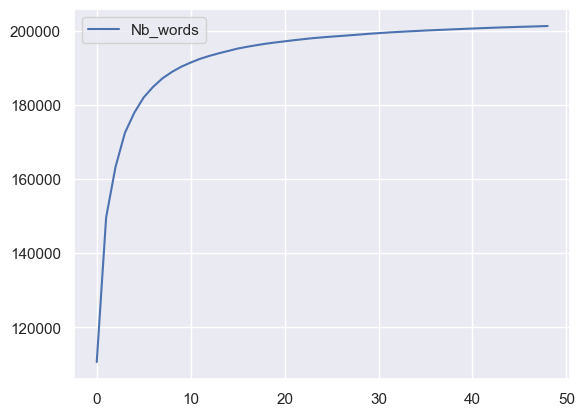

In [66]:
dfr.plot(y="Nb_words")

In [71]:
print ("Proportion des mots apparaissant moins de 8 fois dans le corpus : " + 
       str(round(len(tmp[tmp[tmp<=8]])/len(corpus)*100,2)) + "%")

Proportion des mots apparaissant moins de 8 fois dans le corpus : 2.18%


In [72]:
list_rare_words = tmp[tmp<=8]

In [73]:
# Liste des mots courants propres au domaine de Stackoverflow 

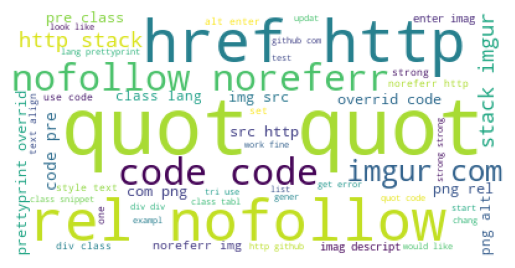

In [74]:
wordcloud = WordCloud(background_color="white",
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [75]:
stop_words.extend(['code', 'quot', 'use', 'http', 'com', 'error', 'work', 'want', 'one', 'would', 'need', 
                   'help', 'also', 'exampl', 'could', 'thing', 'well', 'dear', 'p'])

In [76]:
df.to_csv("data/cleaned/df_cleaned2.csv", index=False)

### <a name="C3.2.3">3.2.3 Nettoyage des textes et des Tags</a>

In [77]:
def suivi_evol_tokens(df, df_res):
    last_raw = len(df_res)
    df_res.loc[last_raw, "nb_tokens_Title"] = sum([len(raw) for raw in df.Title])
    df_res.loc[last_raw, "nb_tokens_Body"] = sum([len(raw) for raw in df.Body])
    df_res.loc[last_raw, "nb_tokens_Tags"] = sum([len(raw) for raw in df.Tags])
    return df_res

In [78]:
def clean_it(doc):
    # Delete the flag <p>
    doc = doc.replace('<p>', ' ').replace('>', ' ').replace('<', ' ')

    # Put the text in lowercase
    doc = doc.lower().strip()

    doc = doc.encode("ascii", "ignore").decode()

    # Remove ponctuation (except # and ++ for c# and c++)
    doc = re.sub('[^\\w\\s#\\s++]', ' ', doc)

    # Remove numbers
    doc = re.sub(r'\w*\d+\w*', ' ', doc)

    # Remove extra spaces
    doc = re.sub('\s+', ' ', doc)
    return doc

# Applying the cleaning function 
df['Title'] = df['Title'].apply(clean_it)
df['Body'] = df['Body'].apply(clean_it)
df['Tags'] = df['Tags'].apply(clean_it)
df[['Title','Body','Tags']].head(10)

,Title,Body,Tags
0,can t find button with selenium webdriver,this is really throwing us i am working on an ...,python html selenium webdriver automation bots
1,how to generate all possible melody strings fo...,i have this question in the math site to figur...,algorithm
2,create access policy for nifi using rest api,i am trying to set an access policy to a nifi ...,python rest apache nifi
3,node gyp ld warning ignoring file file buildin...,i am getting this error in github actions runn...,node gyp
4,update a table based on the existence of a row...,this is a bit confusing to explain but basical...,mysql sql
5,default gitlab ci cd tokens for git commits,i want to git commit to current repo in gitlab...,gitlab
6,how do i go about localizing route uris,let s say i want to translate my web app into ...,laravel
7,azure app service bicep network access restric...,i have a set of azure app services deployed vi...,azure azure resource manager azure appservice ...
8,how does vcenter clone,my boss brought up an interesting question how...,clone vmware vcenter
9,send datatable records to a form,i am creating an asset management system where...,javascript html jquery ajax datatables


In [79]:
nb_tokens_Title = sum([(ligne.count(" ")+1) for ligne in df.Title])
nb_tokens_Body  = sum([(ligne.count(" ")+1) for ligne in df.Body])  
nb_tokens_Tags  = sum([(ligne.count(" ")+1) for ligne in df.Tags])
ar = np.array([[nb_tokens_Title, nb_tokens_Body, nb_tokens_Tags]])
df_res = pd.DataFrame(ar, columns=["nb_tokens_Title", "nb_tokens_Body", "nb_tokens_Tags"])

In [80]:
def tokenize_it(doc):
    tokenizer = RegexpTokenizer(r"\w+")
    doc = tokenizer.tokenize(doc)
    return doc

df['Title'] = df['Title'].apply(lambda text: tokenize_it(text))
df['Body'] = df['Body'].apply(lambda text: tokenize_it(text))
df['Tags'] = df['Tags'].apply(lambda text: tokenize_it(text))
df_res = suivi_evol_tokens(df, df_res)
df[['Title','Body','Tags']].head(10)

,Title,Body,Tags
0,"[can, t, find, button, with, selenium, webdriver]","[this, is, really, throwing, us, i, am, workin...","[python, html, selenium, webdriver, automation..."
1,"[how, to, generate, all, possible, melody, str...","[i, have, this, question, in, the, math, site,...",[algorithm]
2,"[create, access, policy, for, nifi, using, res...","[i, am, trying, to, set, an, access, policy, t...","[python, rest, apache, nifi]"
3,"[node, gyp, ld, warning, ignoring, file, file,...","[i, am, getting, this, error, in, github, acti...","[node, gyp]"
4,"[update, a, table, based, on, the, existence, ...","[this, is, a, bit, confusing, to, explain, but...","[mysql, sql]"
5,"[default, gitlab, ci, cd, tokens, for, git, co...","[i, want, to, git, commit, to, current, repo, ...",[gitlab]
6,"[how, do, i, go, about, localizing, route, uris]","[let, s, say, i, want, to, translate, my, web,...",[laravel]
7,"[azure, app, service, bicep, network, access, ...","[i, have, a, set, of, azure, app, services, de...","[azure, azure, resource, manager, azure, appse..."
8,"[how, does, vcenter, clone]","[my, boss, brought, up, an, interesting, quest...","[clone, vmware, vcenter]"
9,"[send, datatable, records, to, a, form]","[i, am, creating, an, asset, management, syste...","[javascript, html, jquery, ajax, datatables]"


In [81]:
def lemmatize_it(doc):
    doc = [trans.lemmatize(w) for w in doc]
    return doc

trans = WordNetLemmatizer()
df['Body'] = df['Body'].apply(lemmatize_it)
df['Title'] = df['Title'].apply(lemmatize_it)
df['Tags'] = df['Tags'].apply(lemmatize_it)
df_res = suivi_evol_tokens(df, df_res)
df[['Body','Title','Tags']].head(10)

,Body,Title,Tags
0,"[this, is, really, throwing, u, i, am, working...","[can, t, find, button, with, selenium, webdriver]","[python, html, selenium, webdriver, automation..."
1,"[i, have, this, question, in, the, math, site,...","[how, to, generate, all, possible, melody, str...",[algorithm]
2,"[i, am, trying, to, set, an, access, policy, t...","[create, access, policy, for, nifi, using, res...","[python, rest, apache, nifi]"
3,"[i, am, getting, this, error, in, github, acti...","[node, gyp, ld, warning, ignoring, file, file,...","[node, gyp]"
4,"[this, is, a, bit, confusing, to, explain, but...","[update, a, table, based, on, the, existence, ...","[mysql, sql]"
5,"[i, want, to, git, commit, to, current, repo, ...","[default, gitlab, ci, cd, token, for, git, com...",[gitlab]
6,"[let, s, say, i, want, to, translate, my, web,...","[how, do, i, go, about, localizing, route, uris]",[laravel]
7,"[i, have, a, set, of, azure, app, service, dep...","[azure, app, service, bicep, network, access, ...","[azure, azure, resource, manager, azure, appse..."
8,"[my, bos, brought, up, an, interesting, questi...","[how, doe, vcenter, clone]","[clone, vmware, vcenter]"
9,"[i, am, creating, an, asset, management, syste...","[send, datatable, record, to, a, form]","[javascript, html, jquery, ajax, datatables]"


In [82]:
tags_list  = [token for token_list in df.Tags for token in token_list]
tags_list = list(set(tags_list))
tags_list.sort()
len(tags_list)

12852

In [278]:
df.to_csv("data/cleaned/df_cleaned3.csv", index=False)

In [83]:
# Remove the stopwords
def remove_stopwords(raw):
    words = [w for w in raw if w not in stop_words ]
    return words 

df.Body = df.Body.apply(lambda word : remove_stopwords(word))
df.Title = df.Title.apply(lambda word : remove_stopwords(word))
df_res = suivi_evol_tokens(df, df_res)
df[['Body','Title','Tags']].head(10)

,Body,Title,Tags
0,"[really, throwing, u, working, indeed, applica...","[find, button, selenium, webdriver]","[python, html, selenium, webdriver, automation..."
1,"[question, math, site, figure, calculate, numb...","[generate, possible, melody, string, melody, g...",[algorithm]
2,"[trying, set, access, policy, nifi, instance, ...","[create, access, policy, nifi, using, rest, api]","[python, rest, apache, nifi]"
3,"[getting, github, action, running, macos, like...","[node, gyp, ld, warning, ignoring, file, file,...","[node, gyp]"
4,"[bit, confusing, explain, basically, got, pare...","[update, table, based, existence, row, subtable]","[mysql, sql]"
5,"[git, commit, current, repo, gitlab, ci, cd, p...","[default, gitlab, ci, cd, token, git, commits]",[gitlab]
6,"[let, say, translate, web, app, multiple, lang...","[go, localizing, route, uris]",[laravel]
7,"[set, azure, app, service, deployed, via, bice...","[azure, app, service, bicep, network, access, ...","[azure, azure, resource, manager, azure, appse..."
8,"[bos, brought, interesting, question, vcenter,...","[doe, vcenter, clone]","[clone, vmware, vcenter]"
9,"[creating, asset, management, system, informat...","[send, datatable, record, form]","[javascript, html, jquery, ajax, datatables]"


In [84]:
# Keep the most used words (>8 in the corpus)
def remove_rare_words(raw):
    words = [w for w in raw if w not in list_rare_words ]
    return words 

df.Body = df.Body.apply(lambda word : remove_rare_words(word))
df.Title = df.Title.apply(lambda word : remove_rare_words(word))
df_res = suivi_evol_tokens(df, df_res)
df[['Title','Body','Tags']].head(10)

,Title,Body,Tags
0,"[find, button, selenium, webdriver]","[really, throwing, working, indeed, applicatio...","[python, html, selenium, webdriver, automation..."
1,"[generate, possible, melody, string, melody, g...","[question, math, site, calculate, number, comb...",[algorithm]
2,"[access, policy, nifi, using, rest, api]","[trying, set, access, policy, nifi, instance, ...","[python, rest, apache, nifi]"
3,"[node, gyp, ld, warning, ignoring, file, file,...","[getting, github, action, running, macos, like...","[node, gyp]"
4,"[table, based, existence, row, subtable]","[bit, confusing, explain, basically, got, pare...","[mysql, sql]"
5,"[default, gitlab, ci, cd, token, git, commits]","[git, commit, current, repo, gitlab, ci, cd, p...",[gitlab]
6,"[go, localizing, route, uris]","[let, say, translate, web, app, multiple, lang...",[laravel]
7,"[azure, app, service, bicep, network, access, ...","[set, azure, app, service, deployed, via, bice...","[azure, azure, resource, manager, azure, appse..."
8,"[doe, vcenter, clone]","[bos, brought, interesting, question, vcenter,...","[clone, vmware, vcenter]"
9,"[send, datatable, record, form]","[creating, asset, management, system, informat...","[javascript, html, jquery, ajax, datatables]"


In [85]:
# Suppression des doublons
df.Tags = df.Tags.apply(lambda raw : list(set(raw)))
df.Title = df.Title.apply(lambda raw : list(set(raw)))
df.Body = df.Body.apply(lambda raw : list(set(raw)))

In [86]:
df_res = suivi_evol_tokens(df, df_res)
df[['Title','Body','Tags']].head(10)

,Title,Body,Tags
0,"[selenium, button, webdriver, find]","[loosing, page, left, focus, href, working, cl...","[automation, html, webdriver, bot, selenium, p..."
1,"[duplicate, possible, beat, melody, generator,...","[question, bat, note, get, href, simply, gener...",[algorithm]
2,"[policy, rest, access, nifi, api, using]","[policy, following, set, rest, instance, get, ...","[apache, nifi, rest, python]"
3,"[building, built, gyp, ignoring, macos, file, ...","[arch, github, set, gyp, macos, getting, sure,...","[gyp, node]"
4,"[based, table, existence, subtable, row]","[fruit, table, select, enabled, seeing, fruits...","[mysql, sql]"
5,"[commits, gitlab, cd, git, ci, default, token]","[paid, current, commit, gitlab, cd, default, g...",[gitlab]
6,"[route, uris, go, localizing]","[register, go, multiple, route, french, versio...",[laravel]
7,"[service, public, app, access, restriction, az...","[image, networking, src, explorer, checked, fa...","[appservice, manager, azure, bicep, resource]"
8,"[vcenter, doe, clone]","[bos, question, interesting, href, helpful, so...","[vcenter, vmware, clone]"
9,"[record, datatable, send, form]","[op, method, place, zerorecords, ready, respon...","[html, javascript, datatables, ajax, jquery]"


## <a name="C3.3">3.3 Analyse textuelle</a>

### <a name="C3.3.1">3.3.1 Représentation visuelle</a>

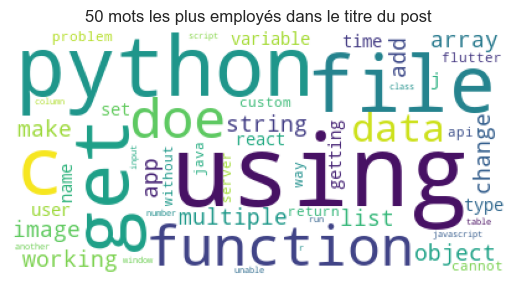

In [165]:
Title_tokens = [token for token_list in df.Title for token in token_list]
wordcloud = WordCloud(background_color="white",
                     stopwords=[],
                     max_words=50).generate(" ".join(Title_tokens))
plt.imshow(wordcloud)
plt.title("50 mots les plus employés dans le titre du post")
plt.axis("off")
plt.show()

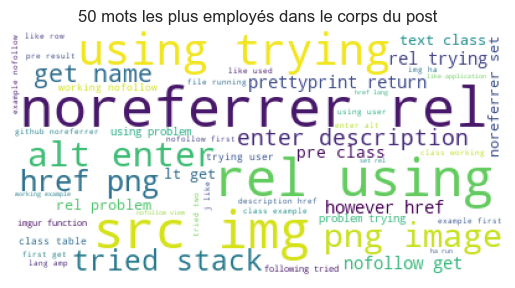

In [287]:
Body_tokens = [token for token_list in df.Body for token in token_list]
wordcloud = WordCloud(background_color="white",
                     stopwords=[],
                     max_words=50).generate(" ".join(Body_tokens))
plt.imshow(wordcloud)
plt.title("50 mots les plus employés dans le corps du post")
plt.axis("off")
plt.show()

In [87]:
df_res

,nb_tokens_Title,nb_tokens_Body,nb_tokens_Tags
0,1086316.0,14629797.0,417046.0
1,1052035.0,14601450.0,410025.0
2,1052035.0,14601450.0,410025.0
3,665921.0,7793895.0,410025.0
4,623378.0,7159925.0,410025.0
5,602429.0,4086091.0,370636.0


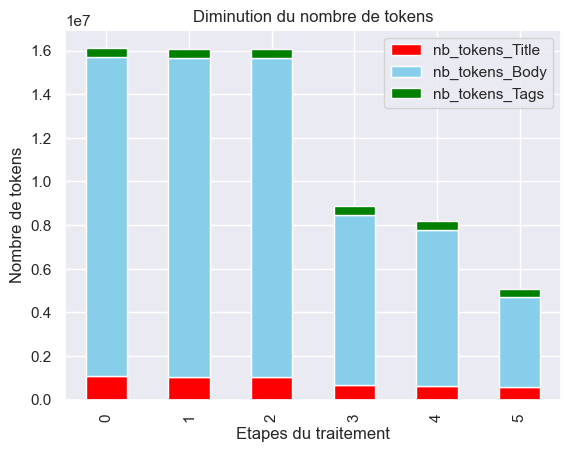

In [90]:
# Visualization with a stacked bar chart 
df_res.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'], )
 
plt.xlabel('Etapes du traitement')
plt.ylabel('Nombre de tokens')
 
plt.title('Diminution du nombre de tokens')
plt.show()

### <a name="C3.3.2">3.3.2 Analyse de la distribution des tokens</a>

In [93]:
df.head(10)

,Title,Body,Tags,Language,nb_tokens_Title,nb_tokens_Body,nb_tokens_shared
0,"[selenium, button, webdriver, find]","[loosing, page, left, focus, href, working, cl...","[automation, html, webdriver, bot, selenium, p...",java,4,40,2
1,"[duplicate, possible, beat, melody, generator,...","[question, bat, note, get, href, simply, gener...",[algorithm],haskell,9,35,7
2,"[policy, rest, access, nifi, api, using]","[policy, following, set, rest, instance, get, ...","[apache, nifi, rest, python]",haskell,6,14,6
3,"[building, built, gyp, ignoring, macos, file, ...","[arch, github, set, gyp, macos, getting, sure,...","[gyp, node]",haskell,11,16,4
4,"[based, table, existence, subtable, row]","[fruit, table, select, enabled, seeing, fruits...","[mysql, sql]",c#,5,50,3
5,"[commits, gitlab, cd, git, ci, default, token]","[paid, current, commit, gitlab, cd, default, g...",[gitlab],NaN,7,11,6
6,"[route, uris, go, localizing]","[register, go, multiple, route, french, versio...",[laravel],NaN,4,16,4
7,"[service, public, app, access, restriction, az...","[image, networking, src, explorer, checked, fa...","[appservice, manager, azure, bicep, resource]",NaN,9,41,6
8,"[vcenter, doe, clone]","[bos, question, interesting, href, helpful, so...","[vcenter, vmware, clone]",NaN,3,28,2
9,"[record, datatable, send, form]","[op, method, place, zerorecords, ready, respon...","[html, javascript, datatables, ajax, jquery]",NaN,4,97,3


In [89]:
df['nb_tokens_Title'] = [len(raw) for raw in df.Title]
df['nb_tokens_Body'] = [len(raw) for raw in df.Body]
df['nb_tokens_shared'] = [len(set(a) & set(b)) for a, b in zip(df.Title, df.Body)]

In [120]:
print (f"Nombre total de tokens dans le titre : {df.nb_tokens_Title.sum():,}           \
        avec {df.nb_tokens_shared.sum()/df.nb_tokens_Title.sum()*100:.1f}% de tokens communs")
print (f"Nombre total de tokens dans le corps du post : {df.nb_tokens_Body.sum():,} \
        avec {df.nb_tokens_shared.sum()/df.nb_tokens_Body.sum()*100:.1f}% de tokens communs")
print (f"Nombre total de tokens communs aux 2 : {df.nb_tokens_shared.sum():,}")


Nombre total de tokens dans le titre : 602,429                   avec 67.2% de tokens communs
Nombre total de tokens dans le corps du post : 4,086,091         avec 9.9% de tokens communs
Nombre total de tokens communs aux 2 : 404,867


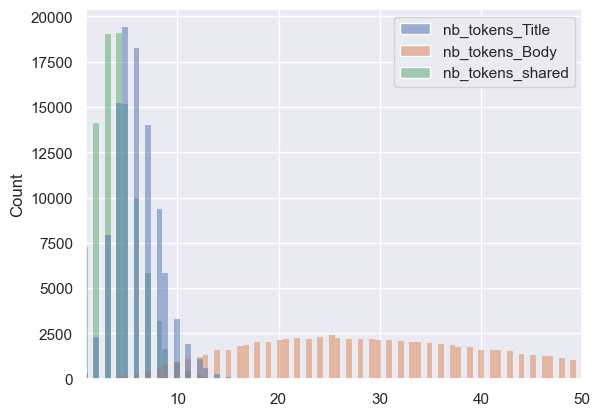

In [121]:
g = sns.histplot(data=df[['nb_tokens_Title', 'nb_tokens_Body', 'nb_tokens_shared']])
g.set_xlim(1, 50)
plt.show()

In [122]:
df['nb_Tags'] = [len(raw) for raw in df.Tags]
df['nb_Tags_shared_Title'] = [len(set(a) & set(b)) for a, b in zip(df.Tags, df.Title)]
df['nb_Tags_shared_Body'] = [len(set(a) & set(b)) for a, b in zip(df.Tags, df.Body)]

In [131]:
df.iloc[2]

Title                            [policy, rest, access, nifi, api, using]
Body                    [policy, following, set, rest, instance, get, ...
Tags                                         [apache, nifi, rest, python]
Language                                                          haskell
nb_tokens_Title                                                         6
nb_tokens_Body                                                         14
nb_tokens_shared                                                        6
nb_Tags                                                                 4
nb_Tags_shared_Title                                                    2
nb_Tags_shared_Body                                                     3
Name: 2, dtype: object

In [129]:
print (f"Nombre total de token dans les tags : {df.nb_Tags.sum():,}")
print (f"Nombre total de tokens communs aux Titres et aux Tags : {df.nb_Tags_shared_Title.sum():,} \
      soit {df.nb_Tags.sum()/df.nb_tokens_Title.sum()*100:.1f}% ")
print (f"Nombre total de tokens communs aux Corps et aux Tags : {df.nb_Tags_shared_Body.sum():,} \
      soit {df.nb_Tags.sum()/df.nb_tokens_Body.sum()*100:.1f}% ")

Nombre total de token dans les tags : 370,636
Nombre total de tokens communs aux Titres et aux Tags : 132,046       soit 61.5% 
Nombre total de tokens communs aux Corps et aux Tags : 177,088       soit 9.1% 


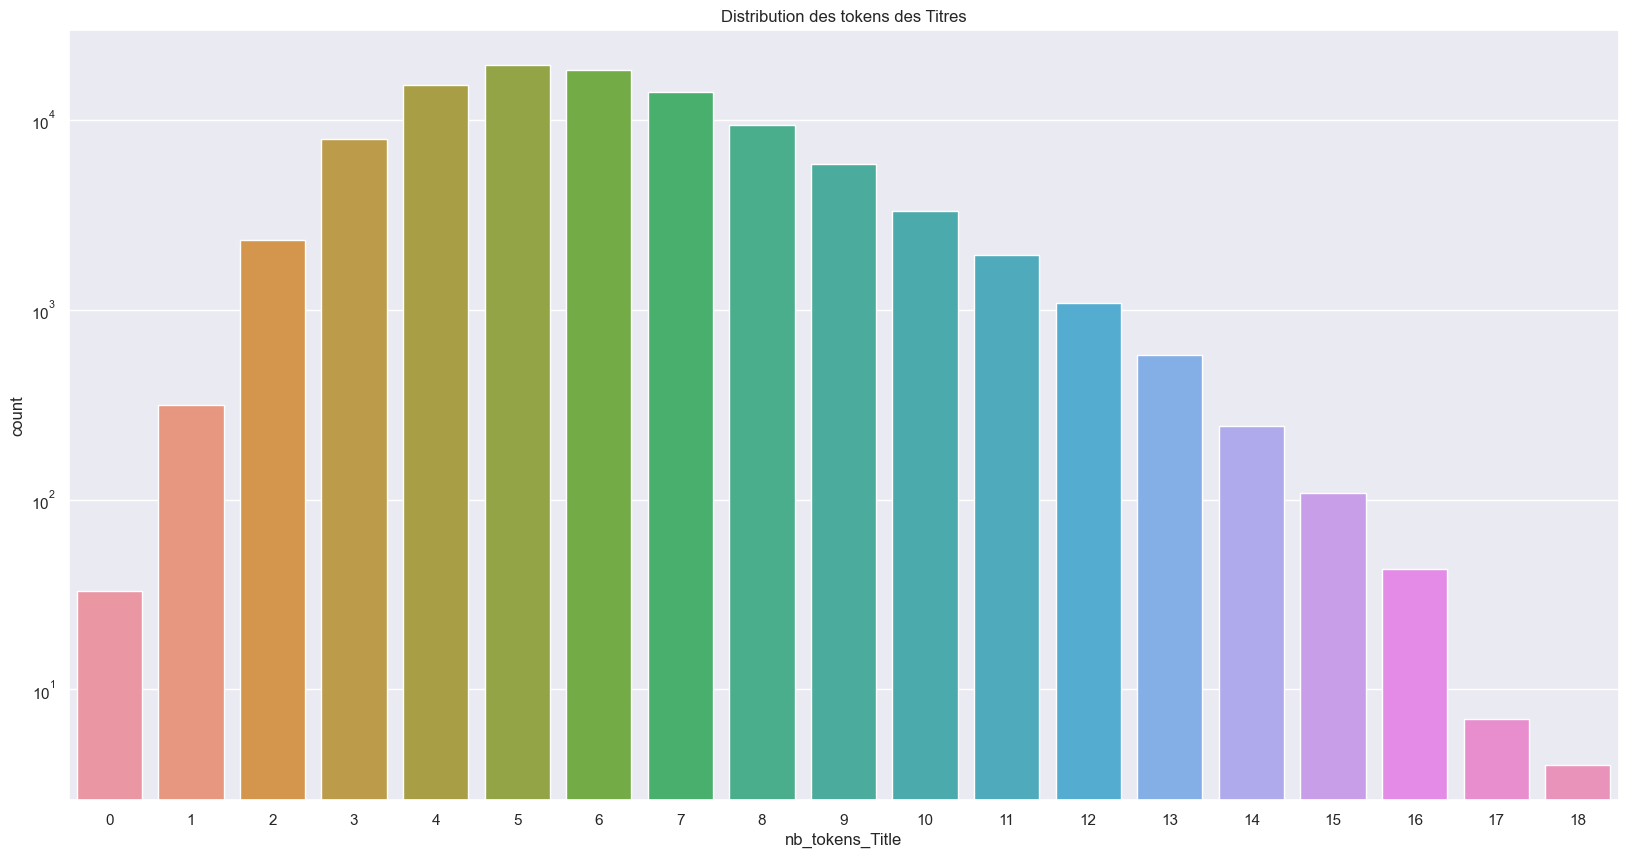

In [144]:
# Titles Countplot 
fig = plt.figure(figsize=(20, 10))
g = sns.countplot(x=df.nb_tokens_Title)
g.set_yscale("log")
plt.title("Distribution des tokens des Titres")
plt.show()

In [155]:
df.nb_tokens_Title.describe()

count    99986.000000
mean         6.025134
std          2.237335
min          0.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         18.000000
Name: nb_tokens_Title, dtype: float64

In [151]:
df.loc[df.nb_tokens_Title == 0]

,Title,Body,Tags,Language,nb_tokens_Title,nb_tokens_Body,nb_tokens_shared,nb_Tags,nb_Tags_shared_Title,nb_Tags_shared_Body
3068,[],"[method, get, getting, version, cause, running...","[objectmapper, automapper, net, mapster, asp]",javascript,0,27,0,5,0,2
10544,[],"[including, pair, format, image, src, two, wit...",[laravel],php,0,48,0,1,0,0
10979,[],"[command, image, docker, repository, version, ...","[kubernetes, registry, docker, helm]",NaN,0,20,0,4,0,2
15029,[],"[please, correctly, implement, able]","[github, npm]",haskell,0,4,0,2,0,0
17543,[],"[malformed, github, form, signal, baseline, ge...","[gym, reinforcement, baseline, learning, tenso...",haskell,0,55,0,7,0,4
21943,[],"[website, table, format, program, replaced, sa...","[dataframe, panda, integer]",NaN,0,61,0,3,0,0
34378,[],"[following, utiliity_function, df_weight, name...","[cvxopt, dataframe, python]",text only,0,18,0,3,0,1
39497,[],"[something, format, ignores, problem, entire, ...","[opengl, e]",text only,0,28,0,2,0,1
40761,[],"[variable, int, inside, cast, cannot, convert,...","[casting, studio, integer, ushort, visual, c]",delphi,0,12,0,6,0,0
40953,[],"[command, pyside, matching, href, problem, org...","[qt, python]",NaN,0,27,0,2,0,0


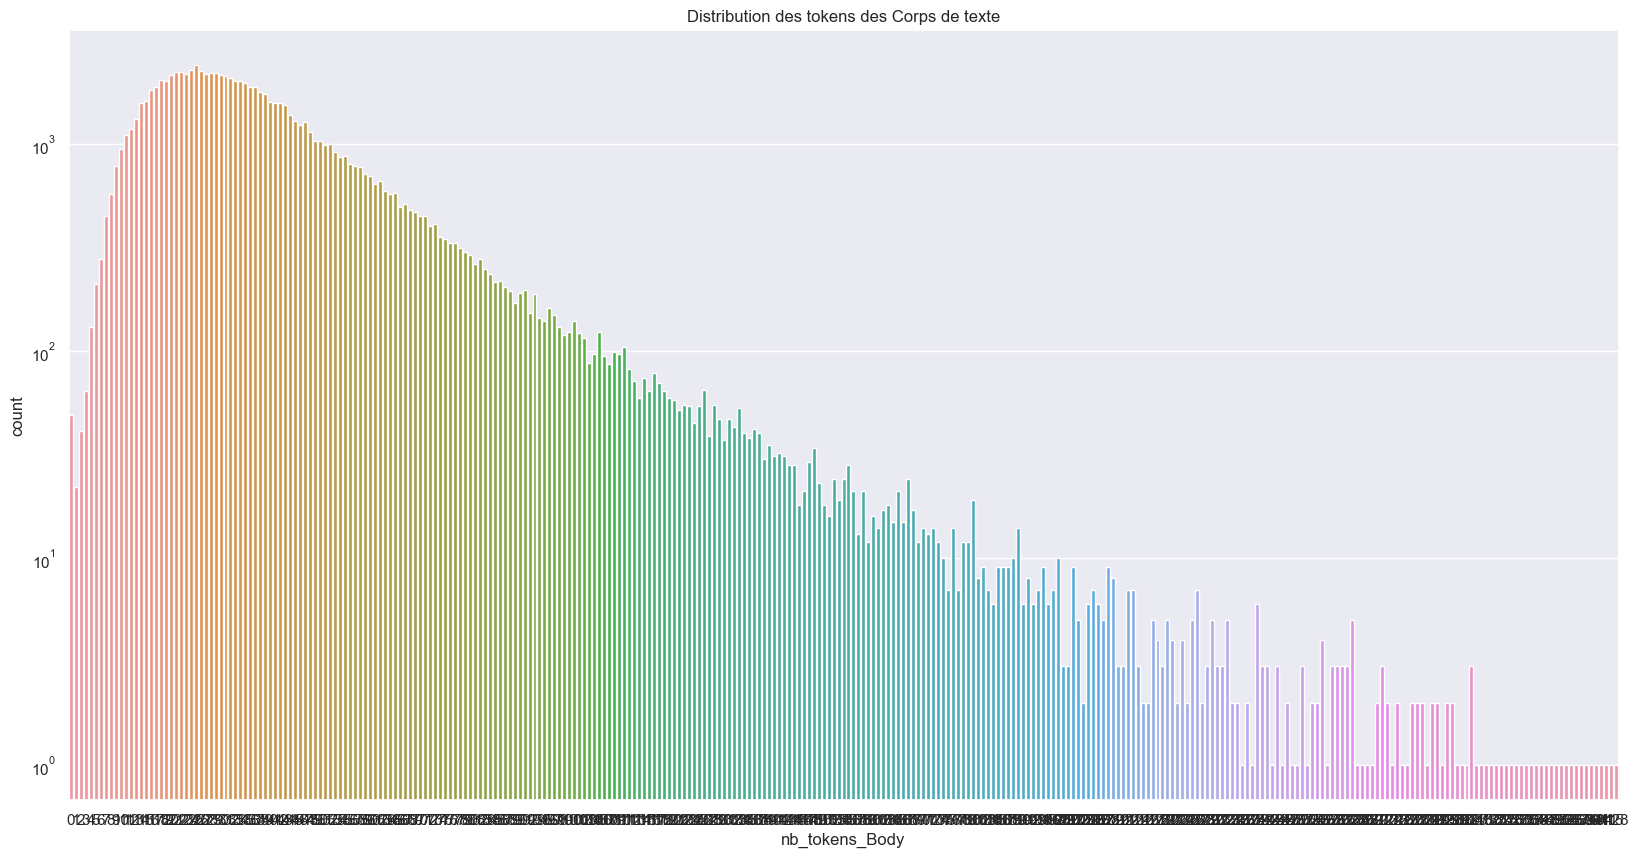

In [156]:
# Bodies Countplot 
fig = plt.figure(figsize=(20, 10))
g = sns.countplot(x=df.nb_tokens_Body)
g.set_yscale("log")
plt.title("Distribution des tokens des Corps de texte")
plt.show()

In [157]:
df.nb_tokens_Body.describe()

count    99986.000000
mean        40.866631
std         28.415929
min          0.000000
25%         23.000000
50%         34.000000
75%         51.000000
max        428.000000
Name: nb_tokens_Body, dtype: float64

In [194]:
df.loc[df.nb_tokens_Body == 0]

,Title,Body,Tags,Language,nb_tokens_Title,nb_tokens_Body,nb_tokens_shared,nb_Tags,nb_Tags_shared_Title,nb_Tags_shared_Body


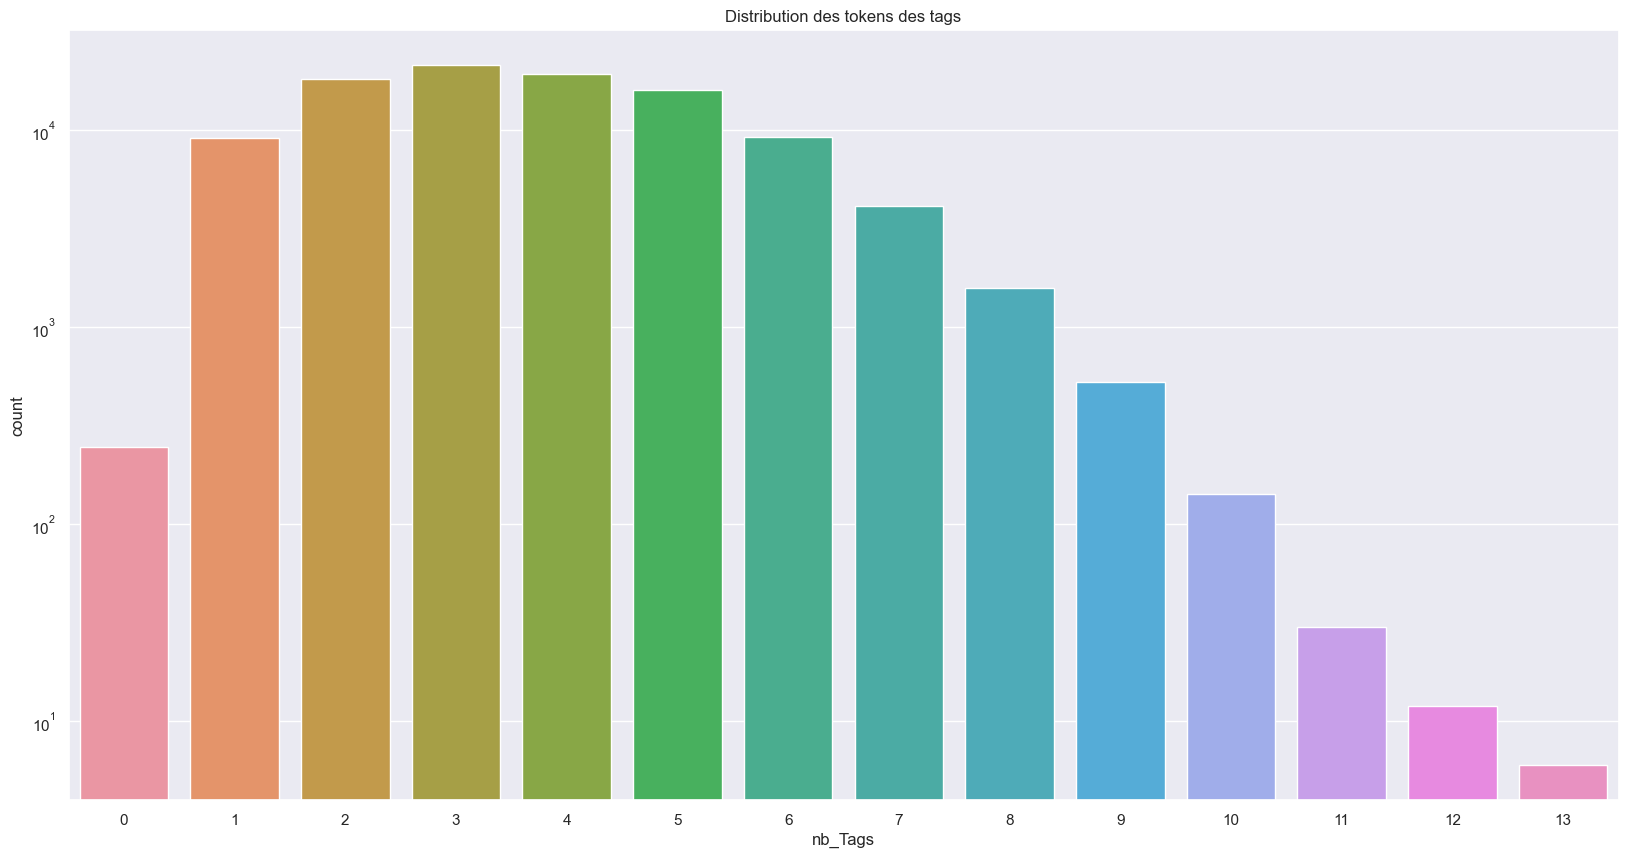

In [168]:
# Tags Countplot 
fig = plt.figure(figsize=(20, 10))
g = sns.countplot(x=df.nb_Tags)
g.set_yscale("log")
plt.title("Distribution des tokens des tags")
plt.show()

In [161]:
df.loc[df.nb_Tags == 0]

,Title,Body,Tags,Language,nb_tokens_Title,nb_tokens_Body,nb_tokens_shared,nb_Tags,nb_Tags_shared_Title,nb_Tags_shared_Body
475,"[size, window, vuejs, globalproperties, screen]","[register, onmounted, instance, get, href, glo...",[],php,5,37,1,0,0,0
572,"[params, getaccesstokensilently, without, happen]","[role, getaccesstokensilently, case, authentic...",[],NaN,4,12,4,0,0,0
786,"[pointer, simple, dat, sample, get, file, void...","[medium, stream, payload, sample, let, know, d...",[],NaN,8,28,4,0,0,0
1093,"[pcb, recognized, drawn, stlink]","[stlink, cannot, drew, problem, reason, pcb, d...",[],NaN,4,23,4,0,0,0
1121,"[upgrade, vaadin]","[connect, add, href, textfield, connector, dow...",[],cpp,2,46,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
99307,"[prime, solving, course]","[coding, prime, solve, explain, tried, instead...",[],haskell,3,14,1,0,0,0
99308,"[migration, pig, question]","[part, github, question, src, queryparser, rep...",[],cpp,3,34,3,0,0,0
99361,"[without, file, archive, compress, name, chang...","[happened, essentially, get, named, appender, ...",[],haskell,6,47,2,0,0,0
99484,"[change, guid, id, type, data, default]","[dbms, version, open, change, guid, conf, sear...",[],NaN,6,21,6,0,0,0


In [167]:
df.to_csv("data/cleaned/df_cleaned6.csv", index=False,header=True,sep=';')

In [176]:
dfc = df.copy()

### <a name="C3.3.3">3.3.2 Nettoyage aprés analyse</a>

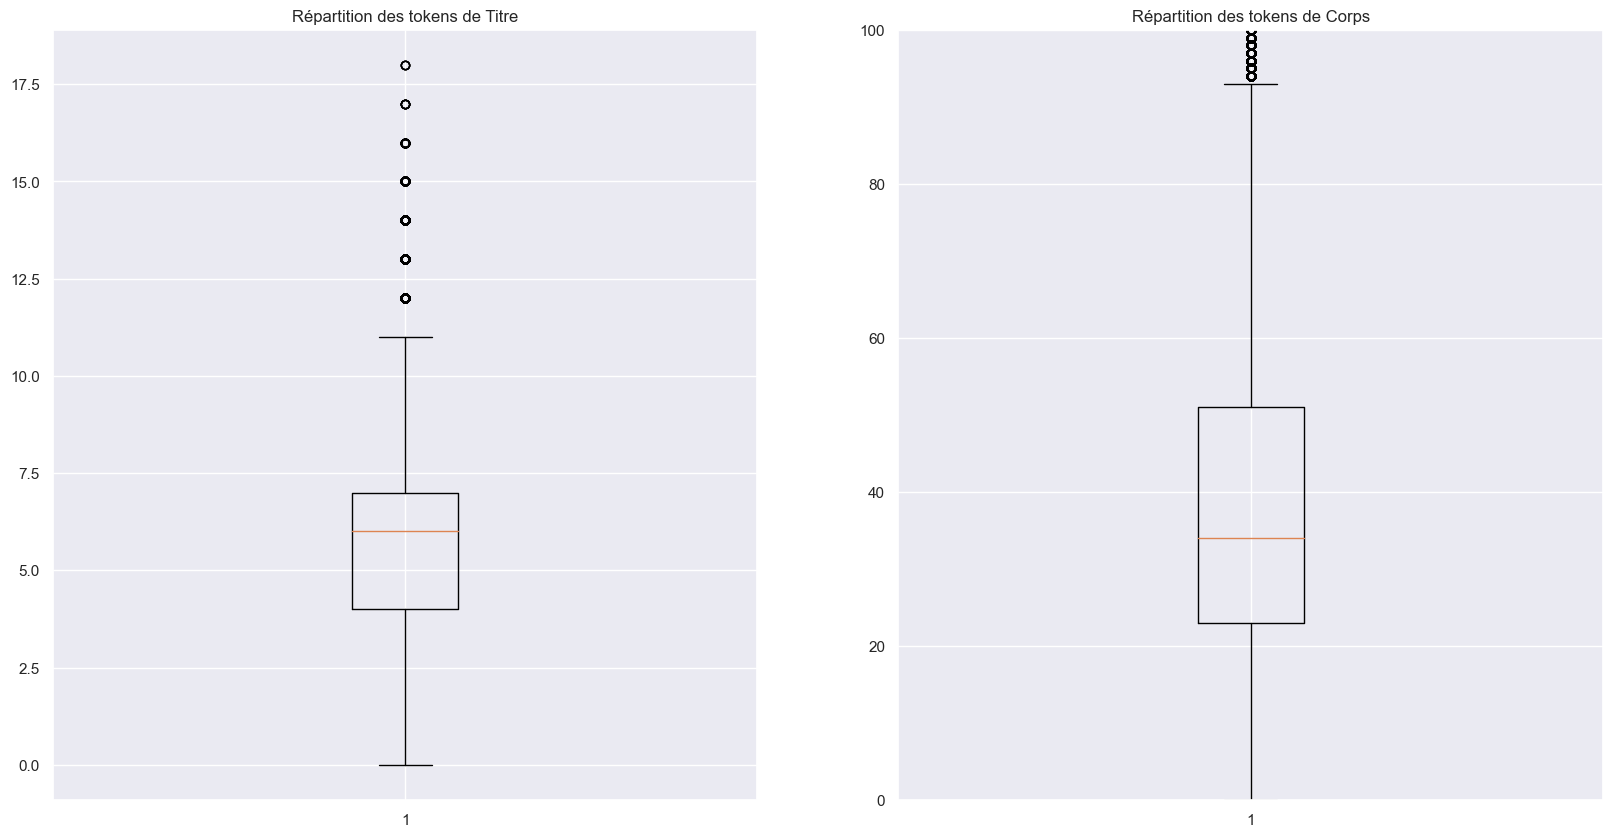

In [189]:
plt.subplot(121)
plt.boxplot(df.nb_tokens_Title)
plt.title('Répartition des tokens de Titre')

plt.subplot(122)
plt.boxplot(df.nb_tokens_Body)
plt.title('Répartition des tokens de Corps')
plt.ylim(0,100)

plt.show()

In [190]:
df = df[(df['nb_tokens_Title']>2)&(df['nb_tokens_Title']<11)]
df = df[(df['nb_tokens_Body']>10)&(df['nb_tokens_Title']<70)]

In [191]:
len(df)

90051

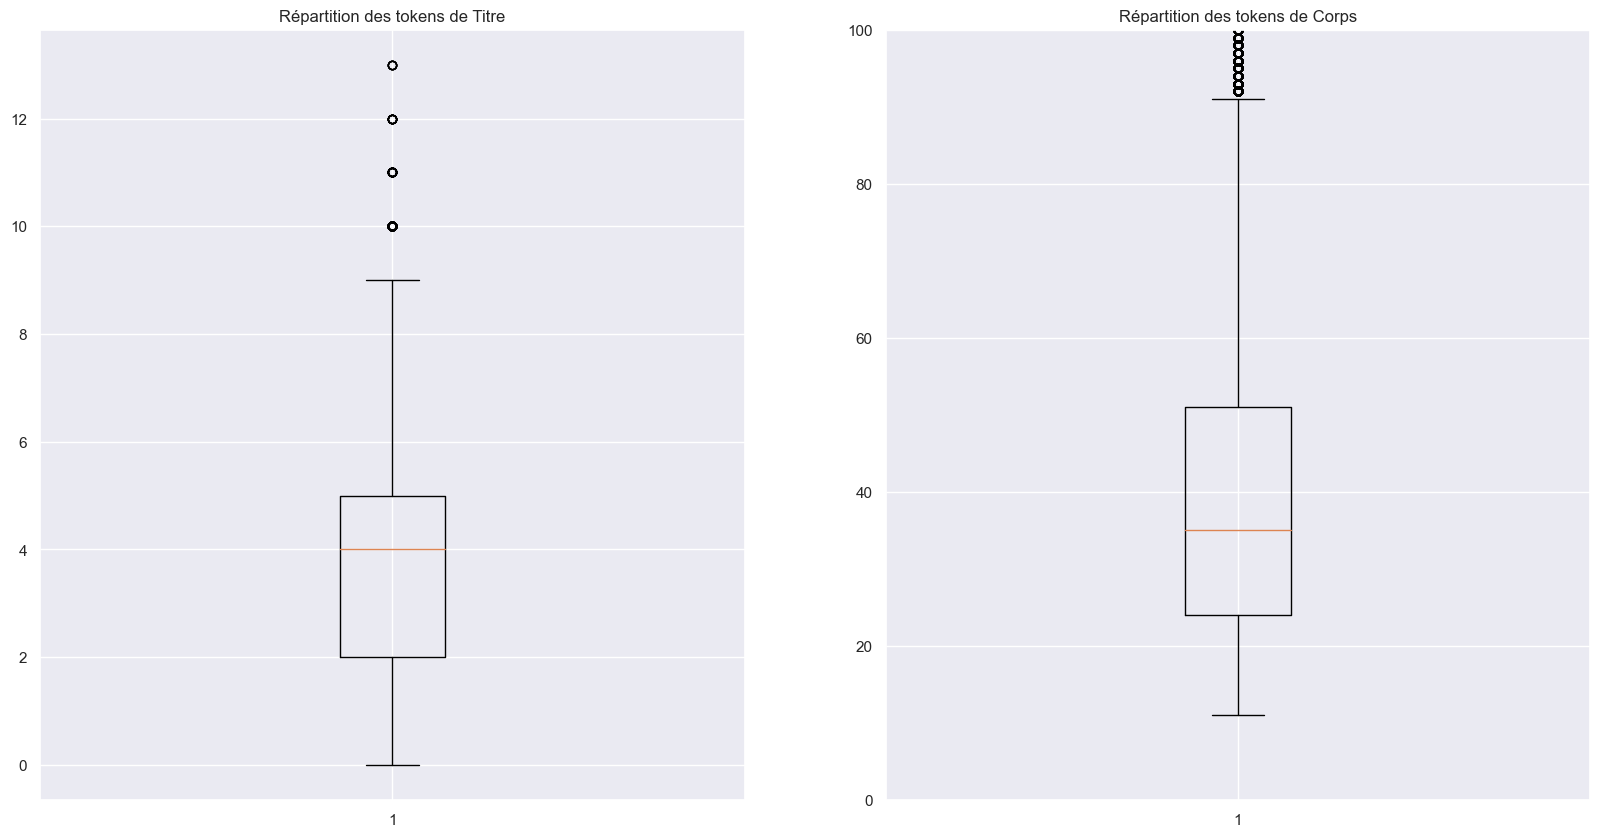

In [199]:
# list of tags tokens
Tag_tokens = [token for token_list in df.Tags for token in token_list]
df_word_freq = pd.DataFrame(nltk.FreqDist(Tag_tokens).items(),columns=['tag', 'frequency']).set_index('tag')
df_word_freq.sort_values("frequency", ascending=False, inplace=True)
df_word_freq.head(100)

,frequency
tag,
python,13888
javascript,8522
c,7026
j,5126
reactjs,4906
...,...
ui,512
tensorflow,494
chrome,478


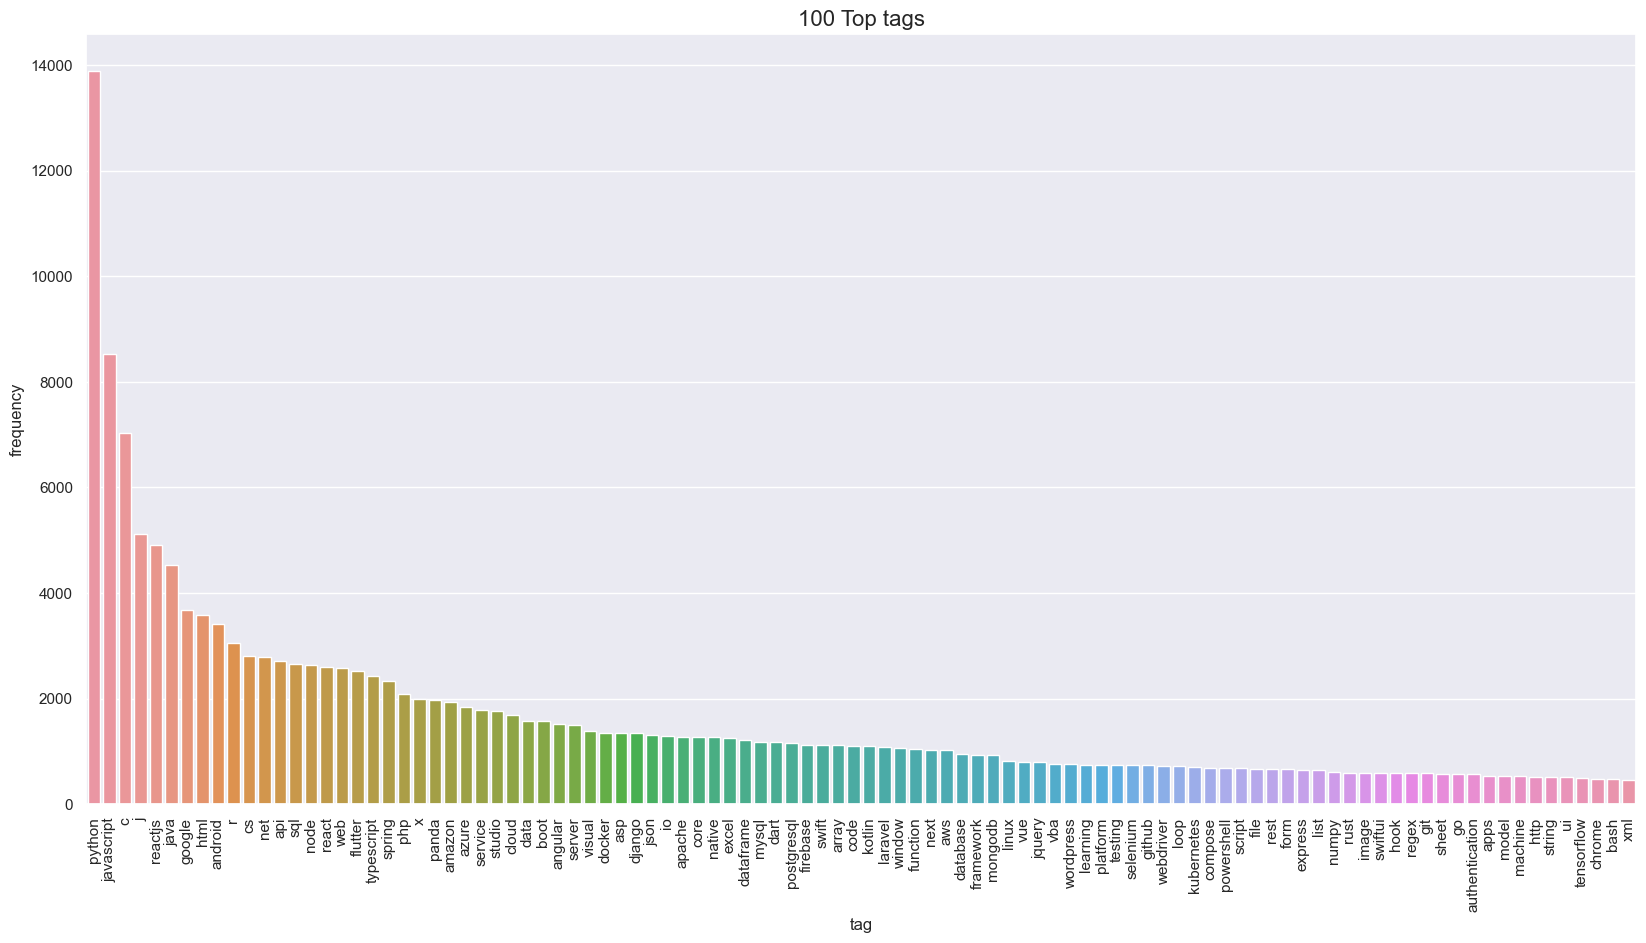

In [200]:
fig = plt.figure(figsize=(20, 10))
sns.barplot(data=df_word_freq.iloc[0:100, :],
            x=df_word_freq.iloc[0:100, :].index,y="frequency")
plt.xticks(rotation=90)
plt.title("100 Top tags",fontsize=16)
plt.show()

In [201]:
# filtering df from the top 100 tags
def filter_tags(raw):
    tokens = [w for w in raw if w in  df_word_freq[0:100].index ]
    return tokens 

df.Tags = df.Tags.apply(lambda word : filter_tags(word))

In [203]:
len(df)

90051

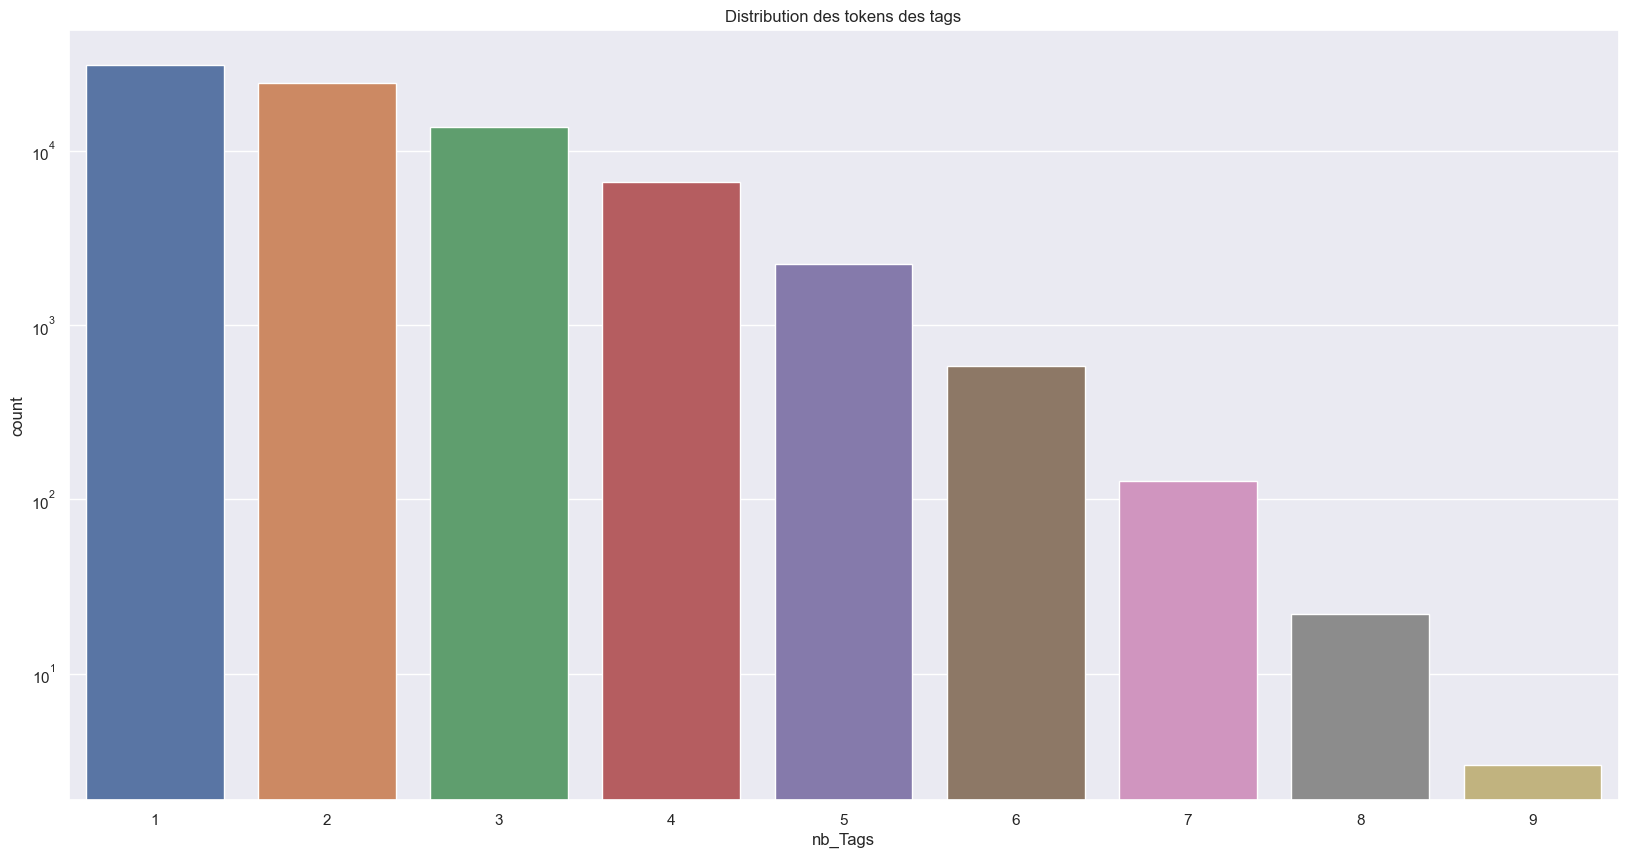

In [204]:
# update the number of tags on each raw
df['nb_Tags'] = [len(raw) for raw in df.Tags]

# delete the raws with zero Tags
df = df[df['nb_Tags']>0]

# Tags Countplot 
fig = plt.figure(figsize=(20, 10))
g = sns.countplot(x=df.nb_Tags)
g.set_yscale("log")
plt.title("Distribution des tokens des tags")
plt.show()

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78451 entries, 0 to 99984
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 78451 non-null  object
 1   Body                  78451 non-null  object
 2   Tags                  78451 non-null  object
 3   Language              51401 non-null  object
 4   nb_tokens_Title       78451 non-null  int64 
 5   nb_tokens_Body        78451 non-null  int64 
 6   nb_tokens_shared      78451 non-null  int64 
 7   nb_Tags               78451 non-null  int64 
 8   nb_Tags_shared_Title  78451 non-null  int64 
 9   nb_Tags_shared_Body   78451 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 6.6+ MB


# <a name="C4">4. Sauvegarde du jeu de données nettoyé</a>

In [214]:
df[['Title', 'Body','Tags']].to_csv("data/cleaned/df_final_version.csv", index=False,header=True,sep=';')